<a href="https://colab.research.google.com/github/shriya2112/PCOS-Diagnosis-Prediction-with-Explainable-ML-Models/blob/main/Copy_of_Project584.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Random Forest Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



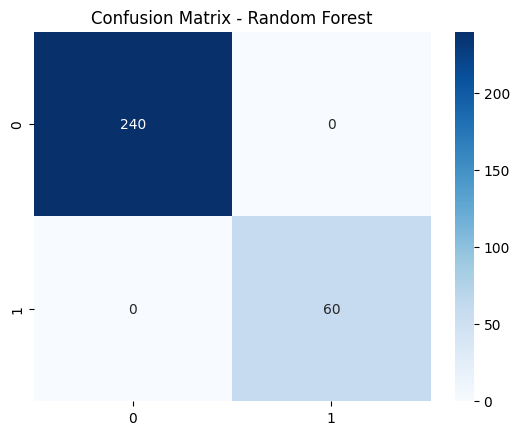

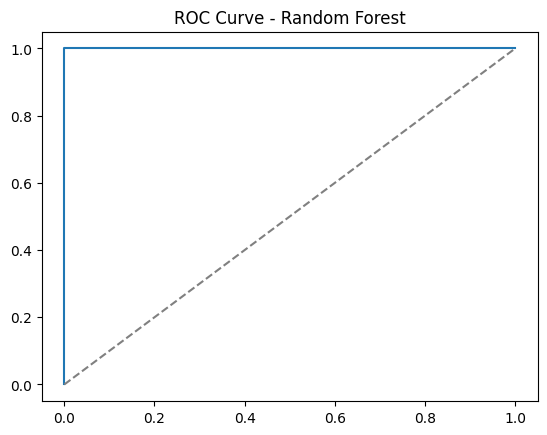


XGBoost Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



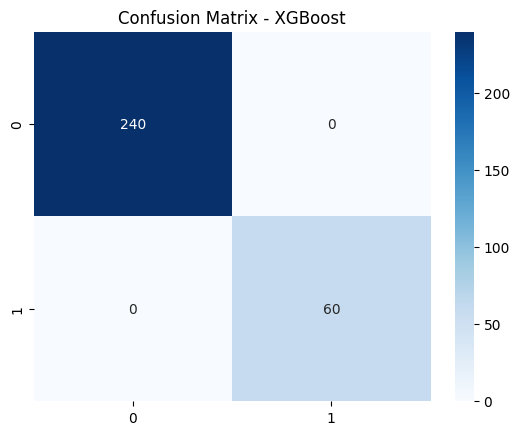

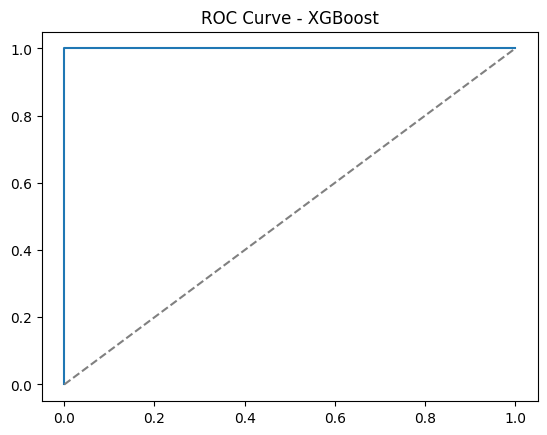


Stacked Ensemble Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



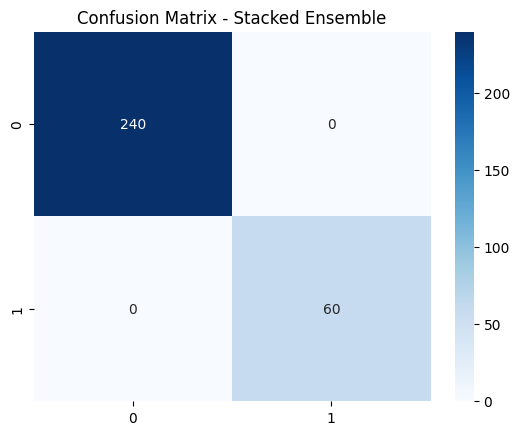

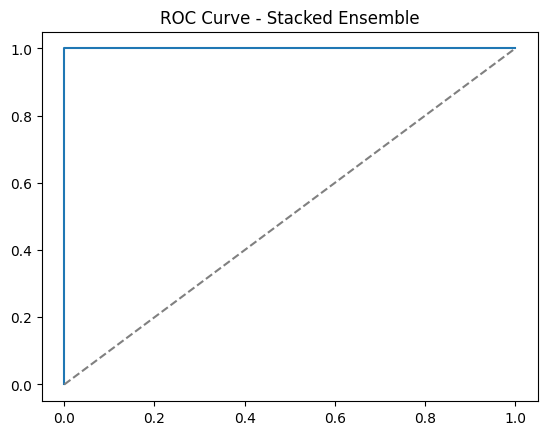

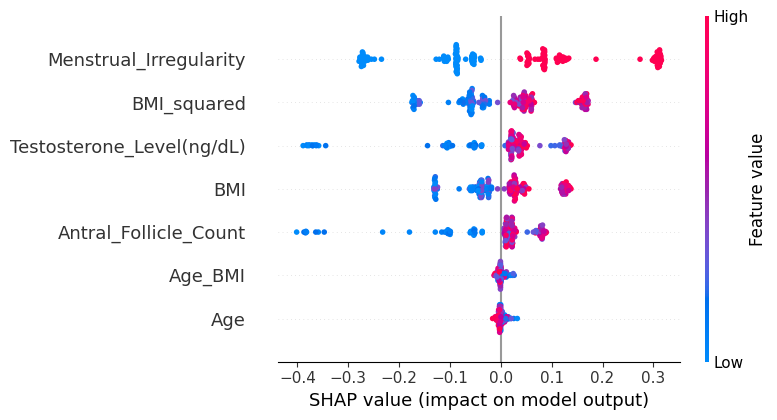

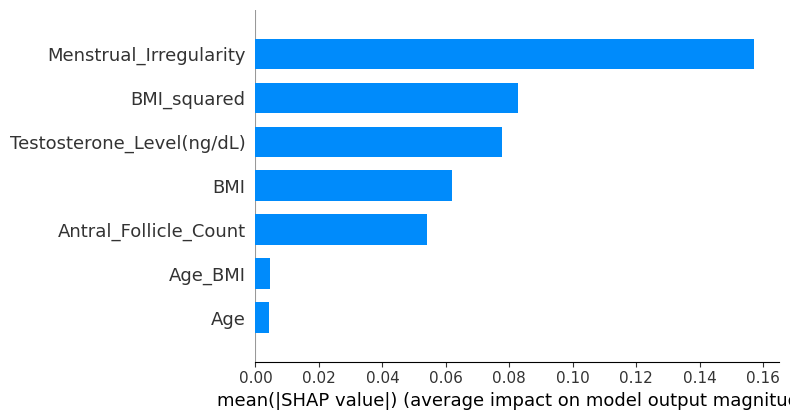


Cross-Validation Scores:
Accuracy: 0.998 ± 0.002
Precision: 1.000 ± 0.000
Recall: 0.990 ± 0.012
F1: 0.995 ± 0.006


In [ ]:
import warnings
warnings.filterwarnings('ignore')  # suppress warnings

# Install required libraries (uncomment if running in Colab)
# !pip install xgboost shap imbalanced-learn umap-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, make_scorer
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import shap
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv('/content/pcos_dataset.csv')

# Create engineered features
df['Age_BMI'] = df['Age'] * df['BMI']
df['BMI_squared'] = df['BMI'] ** 2

# Include diagnostic features to boost model performance
selected_features = [
    'Age', 'BMI', 'Age_BMI', 'BMI_squared',
    'Testosterone_Level(ng/dL)',
    'Menstrual_Irregularity',
    'Antral_Follicle_Count'
]
X = df[selected_features]
y = df['PCOS_Diagnosis']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: UMAP for dimensionality reduction (commented out)
# from umap import UMAP
# reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=5, random_state=42)
# X_umap = reducer.fit_transform(X_scaled)
X_umap = X_scaled  # use scaled features if UMAP unavailable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_umap, y, test_size=0.3, stratify=y, random_state=42
)

# Apply SMOTE ONLY to training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Random Forest GridSearch
rf = RandomForestClassifier(random_state=42)
params_rf = {'n_estimators': [100, 150], 'max_depth': [10, 20]}
grid_rf = GridSearchCV(rf, params_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

# XGBoost GridSearch
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
params_xgb = {'n_estimators': [100], 'max_depth': [5, 7], 'learning_rate': [0.05, 0.1]}
grid_xgb = GridSearchCV(xgb, params_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(X_train, y_train)

# Logistic Regression & Stacking
logreg = LogisticRegression(max_iter=1000, random_state=42)
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', grid_rf.best_estimator_),
        ('xgb', grid_xgb.best_estimator_),
        ('lr', logreg)
    ],
    final_estimator=LogisticRegression(),
    passthrough=True
)
stacking_clf.fit(X_train, y_train)

# Evaluation function
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.title(f'ROC Curve - {name}')
        plt.show()

# Evaluate models
evaluate_model("Random Forest", grid_rf.best_estimator_)
evaluate_model("XGBoost", grid_xgb.best_estimator_)
evaluate_model("Stacked Ensemble", stacking_clf)

# SHAP analysis
rf_shap = RandomForestClassifier(random_state=42)
rf_shap.fit(X, y)
X_sub = shap.sample(X, 200, random_state=42)
explainer = shap.Explainer(rf_shap, X_sub)
shap_values = explainer(X_sub)
shap.summary_plot(shap_values.values[:, :, 1], X_sub, feature_names=selected_features, show=False)
plt.tight_layout(); plt.show()
shap.summary_plot(shap_values.values[:, :, 1], X_sub, feature_names=selected_features, plot_type='bar', show=False)
plt.tight_layout(); plt.show()

# Cross-validation metrics
rf_cv = RandomForestClassifier(
    n_estimators=grid_rf.best_params_['n_estimators'],
    max_depth=grid_rf.best_params_['max_depth'],
    random_state=42
)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}
print("\nCross-Validation Scores:")
for metric, scorer in scorers.items():
    scores = cross_val_score(rf_cv, X_umap, y, cv=skf, scoring=scorer)
    print(f"{metric.capitalize()}: {scores.mean():.3f} ± {scores.std():.3f}")


In [ ]:
# Install required libraries (Google Colab)
!pip install xgboost shap imbalanced-learn umap-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, make_scorer, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import umap
from sklearn.pipeline import Pipeline
import shap
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv('/content/pcos_dataset.csv')

# Create engineered features
df['Age_BMI'] = df['Age'] * df['BMI']
df['BMI_squared'] = df['BMI'] ** 2

# Include diagnostic features to boost model performance
selected_features = [
    'Age', 'BMI', 'Age_BMI', 'BMI_squared',
    'Testosterone_Level(ng/dL)',
    'Menstrual_Irregularity',
    'Antral_Follicle_Count'
]
X = df[selected_features]
y = df['PCOS_Diagnosis']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: UMAP for dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=5, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_umap, y, test_size=0.3, stratify=y, random_state=42)

# Apply SMOTE ONLY to training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Resampled class distribution:\n", pd.Series(y_train).value_counts())

# Random Forest GridSearch
rf = RandomForestClassifier(random_state=42)
params_rf = {'n_estimators':[100,150], 'max_depth':[10, 20]}
grid_rf = GridSearchCV(rf, params_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)
print("Random Forest best parameters:", grid_rf.best_params_)

# XGBoost GridSearch
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
params_xgb = {'n_estimators':[100],'max_depth':[5,7],'learning_rate':[0.05,0.1]}
grid_xgb = GridSearchCV(xgb, params_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(X_train, y_train)
print("XGBoost best parameters:", grid_xgb.best_params_)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', grid_rf.best_estimator_),
        ('xgb', grid_xgb.best_estimator_),
        ('lr', logreg)
    ],
    final_estimator=LogisticRegression(),
    passthrough=True
)
stacking_clf.fit(X_train, y_train)

# Evaluate models
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'AUC = {auc(fpr,tpr):.2f}')
        plt.plot([0,1],[0,1],'--',color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()

# Evaluate each
evaluate_model("Random Forest", grid_rf.best_estimator_)
evaluate_model("XGBoost", grid_xgb.best_estimator_)
evaluate_model("Stacked Ensemble", stacking_clf)

# SHAP Analysis
X_full = df[selected_features]
y_full = df['PCOS_Diagnosis']
rf_shap = RandomForestClassifier(random_state=42)
rf_shap.fit(X_full, y_full)
X_sub = shap.sample(X_full, 200, random_state=42)
explainer = shap.Explainer(rf_shap, X_sub)
shap_values = explainer(X_sub)
shap.summary_plot(shap_values.values[:,:,1], X_sub, feature_names=selected_features, show=False)
plt.tight_layout()
plt.show()
shap.summary_plot(shap_values.values[:,:,1], X_sub, feature_names=selected_features, plot_type='bar', show=False)
plt.tight_layout()
plt.show()

# Cross-validation metrics
rf_cv = RandomForestClassifier(n_estimators=grid_rf.best_params_['n_estimators'], max_depth=grid_rf.best_params_['max_depth'], random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'f1': make_scorer(f1_score)}
print("\nCross-Validation Scores:")
for name, scorer in scorers.items():
    scores = cross_val_score(rf_cv, X_umap, y, cv=skf, scoring=scorer)
    print(f"{name.capitalize()}: {scores.mean():.3f} ± {scores.std():.3f}")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
# prompt: # ─── Step 1: Load Data ───────────────────────────────────────────────────────────────────────────────────────
# df = pd.read_csv('/content/pcos_dataset.csv')
# print(df.head())
# print("Missing values per column:\n", df.isnull().sum())
# # ─── Step 2: Preprocessing ───────────────────────────────────────────────────────────────────────────────────
# features = [
#     'Age',
#     'BMI',
#     'Menstrual_Irregularity',
#     'Testosterone_Level(ng/dL)',
#     'Antral_Follicle_Count'
# ]
# X = df[features]
# y = df['PCOS_Diagnosis']
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# # ─── Step 3: Exploratory Data Analysis ────────────────────────────────────────────────────────────────────────
# sns.countplot(x='PCOS_Diagnosis', data=df)
# plt.title('Class Distribution')
# plt.show()
# plt.figure(figsize=(8,6))
# sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
# plt.title('Correlation Matrix')
# plt.show()
# fig, axs = plt.subplots(1,3, figsize=(18,5))
# sns.boxplot(x='PCOS_Diagnosis', y='BMI', data=df, ax=axs[0])
# axs[0].set_title('BMI by PCOS Status')
# sns.boxplot(x='PCOS_Diagnosis', y='Testosterone_Level(ng/dL)', data=df, ax=axs[1])
# axs[1].set_title('Testosterone by PCOS Status')
# sns.boxplot(x='PCOS_Diagnosis', y='Antral_Follicle_Count', data=df, ax=axs[2])
# axs[2].set_title('Antral Follicle Count by PCOS Status')
# plt.show()
# i want this also to be included in the code

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, make_scorer
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import shap
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import umap
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')  # suppress warnings

# Install required libraries (uncomment if running in Colab)
!pip install xgboost shap imbalanced-learn umap-learn


# ... [rest of your code from the previous response]


Dataset preview:
   Age   BMI  Menstrual_Irregularity  Testosterone_Level(ng/dL)  \
0   24  34.7                       1                       25.2   
1   37  26.4                       0                       57.1   
2   32  23.6                       0                       92.7   
3   28  28.8                       0                       63.1   
4   25  22.1                       1                       59.8   

   Antral_Follicle_Count  PCOS_Diagnosis  
0                     20               0  
1                     25               0  
2                     28               0  
3                     26               0  
4                      8               0   

Missing values per column:
 Age                          0
BMI                          0
Menstrual_Irregularity       0
Testosterone_Level(ng/dL)    0
Antral_Follicle_Count        0
PCOS_Diagnosis               0
dtype: int64 



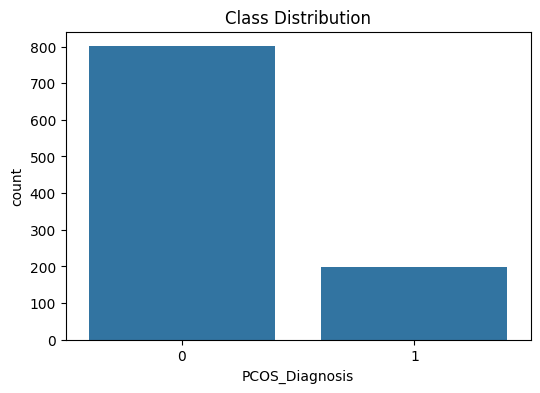

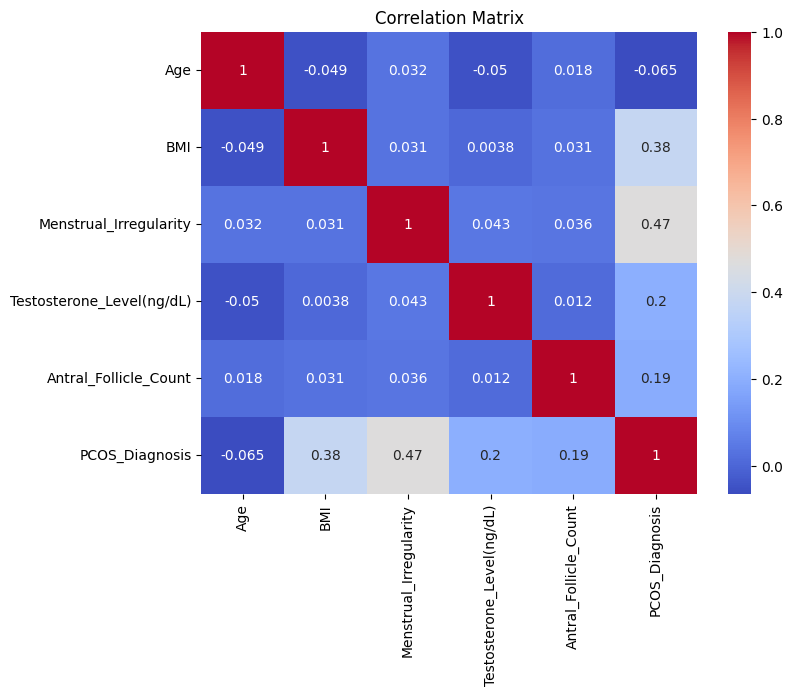

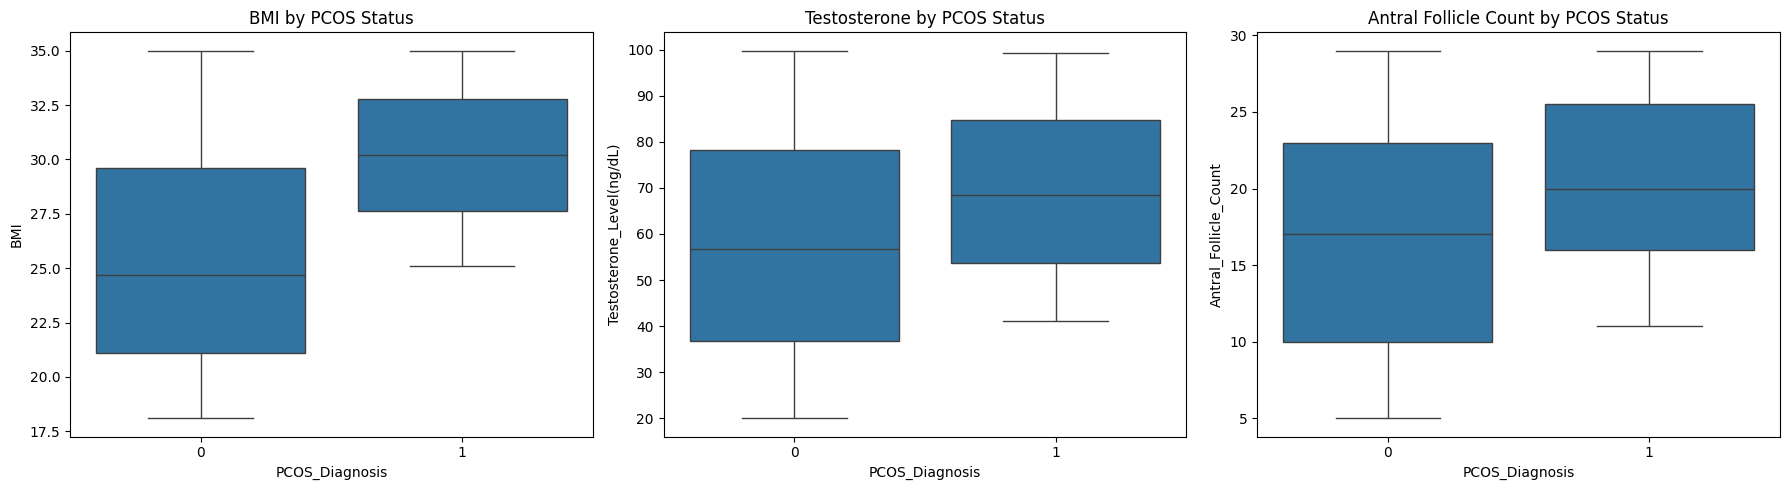

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Age_BMI
- BMI_squared


In [ ]:
import warnings
warnings.filterwarnings('ignore')  # suppress warnings

# ─── Install required libraries (Google Colab) ──────────────────────────────────────────
# !pip install xgboost shap imbalanced-learn umap-learn

# ─── Imports ───────────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    GridSearchCV, cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, make_scorer
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap
# Optional: UMAP (comment out if not installed)
# import umap

# ─── Step 1: Load Data ───────────────────────────────────────────────────────────────────────
df = pd.read_csv('/content/pcos_dataset.csv')
print("Dataset preview:")
print(df.head(), "\n")
print("Missing values per column:\n", df.isnull().sum(), "\n")

# ─── Step 2: Preprocessing ───────────────────────────────────────────────────────────────────
features = [
    'Age',
    'BMI',
    'Menstrual_Irregularity',
    'Testosterone_Level(ng/dL)',
    'Antral_Follicle_Count'
]
X = df[features]
y = df['PCOS_Diagnosis']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ─── Step 3: Exploratory Data Analysis ────────────────────────────────────────────────────────
plt.figure(figsize=(6,4))
sns.countplot(x='PCOS_Diagnosis', data=df)
plt.title('Class Distribution')
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

fig, axs = plt.subplots(1,3, figsize=(18,5))
sns.boxplot(x='PCOS_Diagnosis', y='BMI', data=df, ax=axs[0])
axs[0].set_title('BMI by PCOS Status')
sns.boxplot(x='PCOS_Diagnosis', y='Testosterone_Level(ng/dL)', data=df, ax=axs[1])
axs[1].set_title('Testosterone by PCOS Status')
sns.boxplot(x='PCOS_Diagnosis', y='Antral_Follicle_Count', data=df, ax=axs[2])
axs[2].set_title('Antral Follicle Count by PCOS Status')
plt.tight_layout()
plt.show()

# ─── Step 4: Feature Engineering ───────────────────────────────────────────────────────────
df['Age_BMI']     = df['Age'] * df['BMI']
df['BMI_squared'] = df['BMI'] ** 2

selected_features = features + ['Age_BMI', 'BMI_squared']
X_eng = df[selected_features]

# ─── Step 5: (Optional) UMAP ───────────────────────────────────────────────────────────────
# If UMAP installed, uncomment:
# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=5, random_state=42)
# X_red = reducer.fit_transform(scaler.transform(X_eng))
# else fall back:
X_red = scaler.transform(X_eng)

# ─── Step 6: Train/Test Split & SMOTE ──────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X_red, y, test_size=0.3, stratify=y, random_state=42
)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
print("Resampled class distribution:\n", pd.Series(y_train).value_counts(), "\n")

# ─── Step 7: Hyperparameter Tuning ─────────────────────────────────────────────────────────
# Random Forest
rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(
    rf,
    {'n_estimators':[100,150], 'max_depth':[10,20]},
    cv=5, scoring='accuracy'
).fit(X_train, y_train)
print("RF best params:", grid_rf.best_params_)

# XGBoost
xgb = XGBClassifier(
    random_state=42, use_label_encoder=False, eval_metric='logloss'
)
grid_xgb = GridSearchCV(
    xgb,
    {'n_estimators':[100], 'max_depth':[5,7], 'learning_rate':[0.05,0.1]},
    cv=5, scoring='accuracy'
).fit(X_train, y_train)
print("XGB best params:", grid_xgb.best_params_, "\n")

# Stacking
stack = StackingClassifier(
    estimators=[
        ('rf', grid_rf.best_estimator_),
        ('xgb', grid_xgb.best_estimator_),
        ('lr', LogisticRegression(max_iter=1000, random_state=42))
    ],
    final_estimator=LogisticRegression(),
    passthrough=True
).fit(X_train, y_train)

# ─── Step 8: Evaluation Function ───────────────────────────────────────────────────────────
def evaluate_model(name, model):
    print(f"--- {name} ---")
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.2f}")
        plt.plot([0,1],[0,1],'--',color='gray')
        plt.title(f'ROC Curve - {name}')
        plt.show()

evaluate_model("Random Forest", grid_rf.best_estimator_)
evaluate_model("XGBoost", grid_xgb.best_estimator_)
evaluate_model("Stacking Ensemble", stack)

# ─── Step 9: SHAP Analysis ───────────────────────────────────────────────────────────────
rf_shap = RandomForestClassifier(random_state=42)
rf_shap.fit(X_eng, y)
X_sub = shap.sample(X_eng, 200, random_state=42)
explainer = shap.Explainer(rf_shap, X_sub)
shap_vals = explainer(X_sub)
shap.summary_plot(shap_vals.values[:,:,1], X_sub, feature_names=selected_features, show=False)
plt.tight_layout(); plt.show()
shap.summary_plot(shap_vals.values[:,:,1], X_sub, feature_names=selected_features, plot_type='bar', show=False)
plt.tight_layout(); plt.show()

# ─── Step 10: Cross‑Validation Metrics ────────────────────────────────────────────────────
rf_cv = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score)
}
print("Cross‑Validation Scores (RF):")
for metric, scorer in scorers.items():
    scores = cross_val_score(rf_cv, X_red, y, cv=skf, scoring=scorer)
    print(f"{metric}: {scores.mean():.3f} ± {scores.std():.3f}")


Dataset preview:
   Age   BMI  Menstrual_Irregularity  Testosterone_Level(ng/dL)  \
0   24  34.7                       1                       25.2   
1   37  26.4                       0                       57.1   
2   32  23.6                       0                       92.7   
3   28  28.8                       0                       63.1   
4   25  22.1                       1                       59.8   

   Antral_Follicle_Count  PCOS_Diagnosis  
0                     20               0  
1                     25               0  
2                     28               0  
3                     26               0  
4                      8               0   

Missing values per column:
 Age                          0
BMI                          0
Menstrual_Irregularity       0
Testosterone_Level(ng/dL)    0
Antral_Follicle_Count        0
PCOS_Diagnosis               0
dtype: int64 



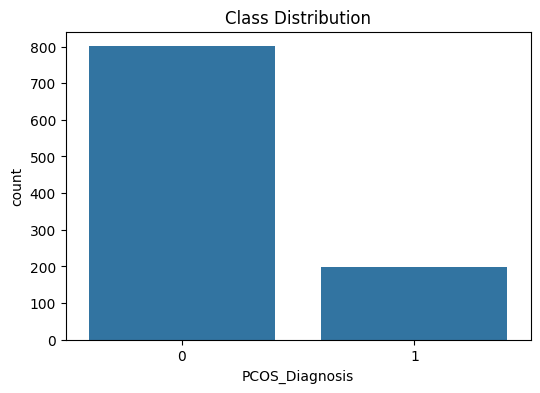

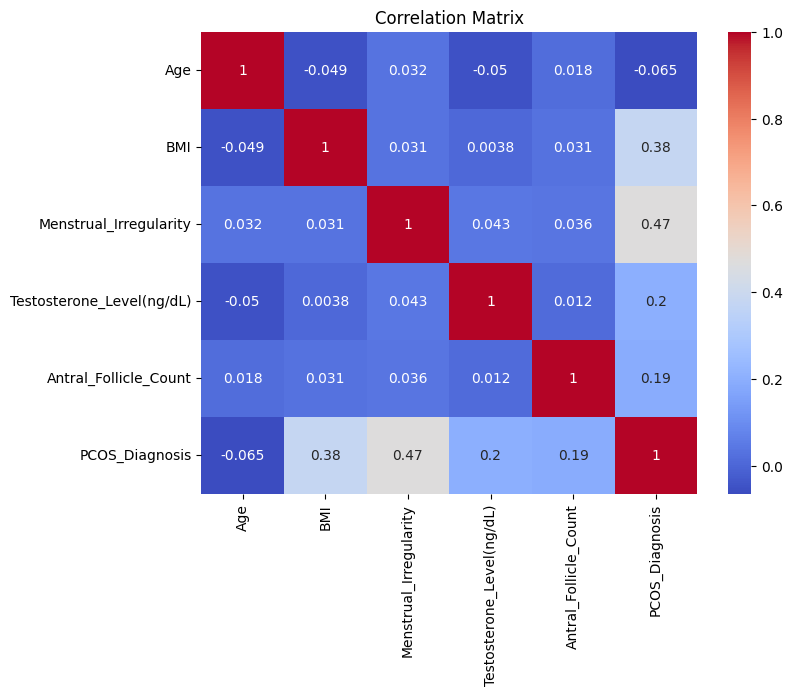

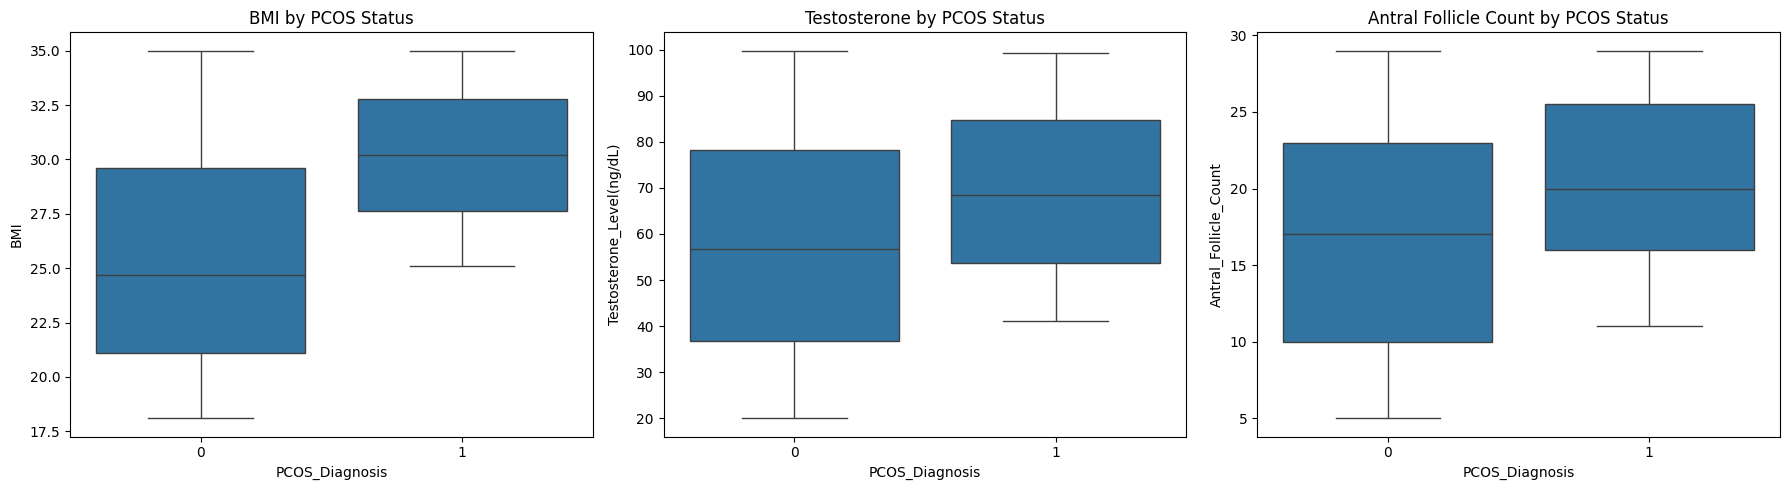

Resampled class distribution:
 PCOS_Diagnosis
0    561
1    561
Name: count, dtype: int64 

RF best params: {'max_depth': 10, 'n_estimators': 100}
XGB best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100} 

--- Random Forest ---
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



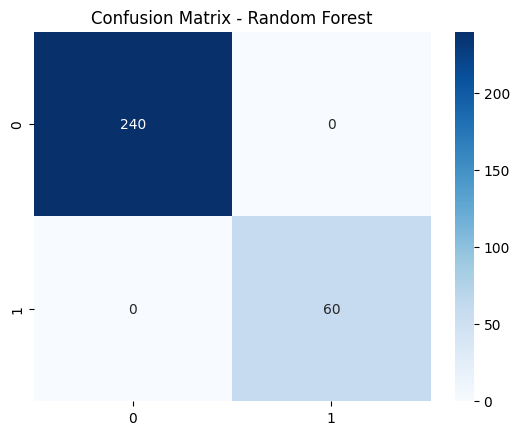

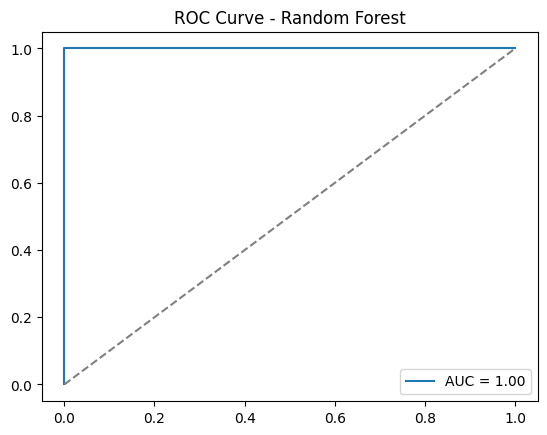

--- XGBoost ---
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



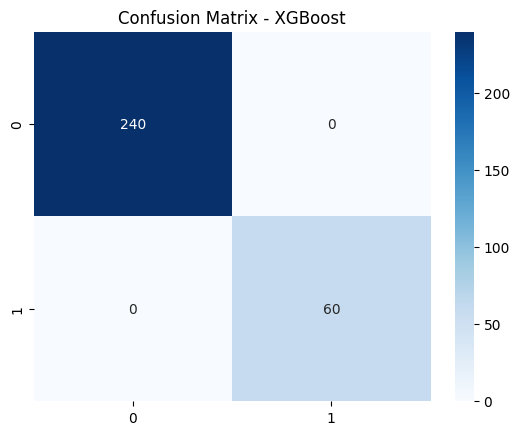

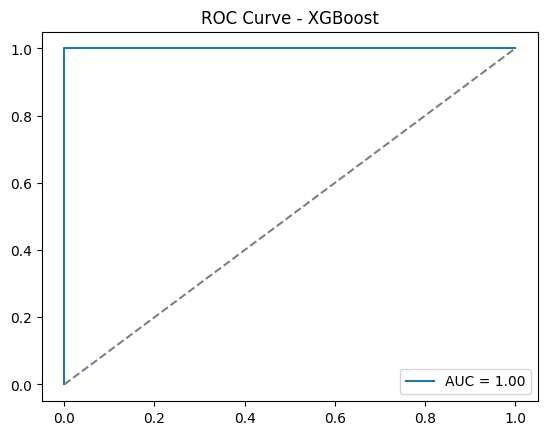

--- Stacked Ensemble ---
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



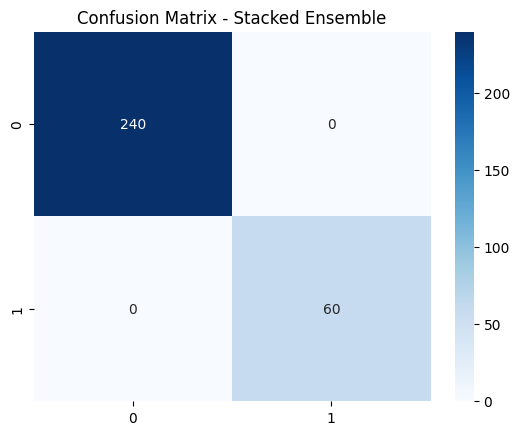

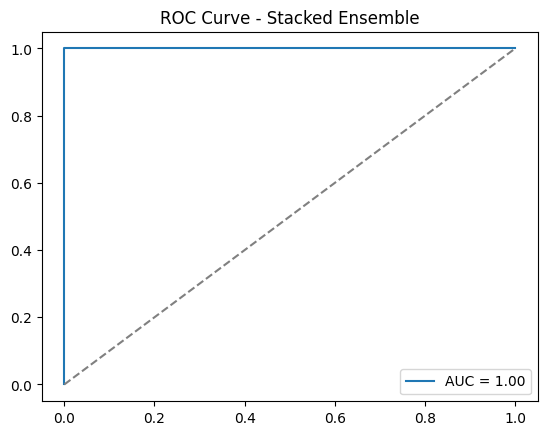

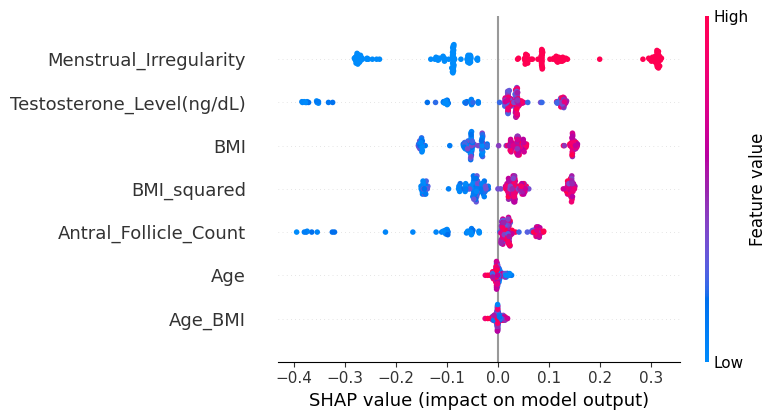

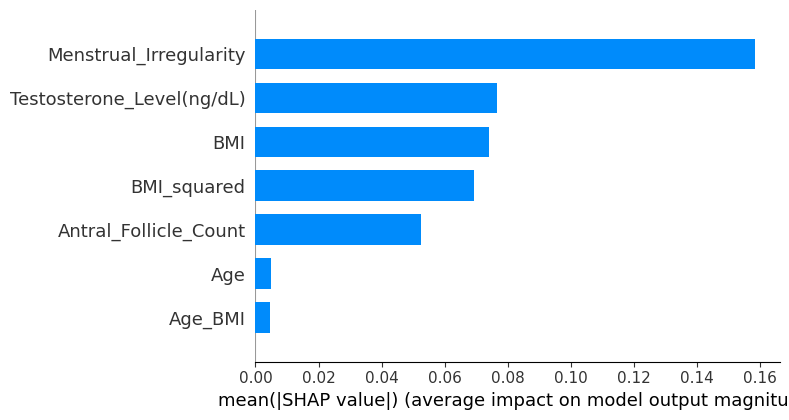

Cross‑Validation Scores (RF):
Accuracy: 0.999 ± 0.002
Precision: 1.000 ± 0.000
Recall: 0.995 ± 0.010
F1: 0.997 ± 0.005


In [ ]:
# ─── Install required libraries (Google Colab) ─────────────────────────────────
!pip install xgboost shap imbalanced-learn umap-learn

# ─── Suppress Warnings ─────────────────────────────────────────────────────────
import warnings
warnings.filterwarnings('ignore')

# ─── Imports ────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
# Optional: UMAP (comment out if not installed)
# import umap

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, make_scorer
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# ─── Step 1: Load Data ────────────────────────────────────────────────────────────
df = pd.read_csv('/content/pcos_dataset.csv')
print("Dataset preview:")
print(df.head(), "\n")
print("Missing values per column:\n", df.isnull().sum(), "\n")

# ─── Step 2: Preprocessing ────────────────────────────────────────────────────────
base_features = [
    'Age',
    'BMI',
    'Menstrual_Irregularity',
    'Testosterone_Level(ng/dL)',
    'Antral_Follicle_Count'
]
X_base = df[base_features]
y      = df['PCOS_Diagnosis']

# ─── Step 3: Exploratory Data Analysis ────────────────────────────────────────────
plt.figure(figsize=(6,4))
sns.countplot(x='PCOS_Diagnosis', data=df)
plt.title('Class Distribution')
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

fig, axs = plt.subplots(1,3, figsize=(18,5))
sns.boxplot(x='PCOS_Diagnosis', y='BMI', data=df, ax=axs[0])
axs[0].set_title('BMI by PCOS Status')
sns.boxplot(x='PCOS_Diagnosis', y='Testosterone_Level(ng/dL)', data=df, ax=axs[1])
axs[1].set_title('Testosterone by PCOS Status')
sns.boxplot(x='PCOS_Diagnosis', y='Antral_Follicle_Count', data=df, ax=axs[2])
axs[2].set_title('Antral Follicle Count by PCOS Status')
plt.tight_layout()
plt.show()

# ─── Step 4: Feature Engineering & Scaling ────────────────────────────────────────
df['Age_BMI']     = df['Age'] * df['BMI']
df['BMI_squared'] = df['BMI'] ** 2

selected_features = base_features + ['Age_BMI', 'BMI_squared']
X_eng = df[selected_features]

# Now fit scaler on all engineered features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_eng)

# ─── Step 5: (Optional) UMAP ─────────────────────────────────────────────────────
# If UMAP is installed, uncomment these lines:
# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=5, random_state=42)
# X_red = reducer.fit_transform(X_scaled)
# Otherwise, just use the scaled features:
X_red = X_scaled

# ─── Step 6: Train/Test Split & SMOTE ─────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X_red, y, test_size=0.3, stratify=y, random_state=42
)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
print("Resampled class distribution:\n", pd.Series(y_train).value_counts(), "\n")

# ─── Step 7: Hyperparameter Tuning ────────────────────────────────────────────────
# Random Forest GridSearch
rf        = RandomForestClassifier(random_state=42)
grid_rf   = GridSearchCV(
    rf,
    {'n_estimators':[100,150], 'max_depth':[10,20]},
    cv=5, scoring='accuracy'
).fit(X_train, y_train)
print("RF best params:", grid_rf.best_params_)

# XGBoost GridSearch
xgb       = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
grid_xgb  = GridSearchCV(
    xgb,
    {'n_estimators':[100], 'max_depth':[5,7], 'learning_rate':[0.05,0.1]},
    cv=5, scoring='accuracy'
).fit(X_train, y_train)
print("XGB best params:", grid_xgb.best_params_, "\n")

# Stacked Ensemble
stack_clf = StackingClassifier(
    estimators=[
        ('rf', grid_rf.best_estimator_),
        ('xgb', grid_xgb.best_estimator_),
        ('lr', LogisticRegression(max_iter=1000, random_state=42))
    ],
    final_estimator=LogisticRegression(),
    passthrough=True
).fit(X_train, y_train)

# ─── Step 8: Evaluation ────────────────────────────────────────────────────────────
def evaluate_model(name, model):
    print(f"--- {name} ---")
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.2f}")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()

evaluate_model("Random Forest", grid_rf.best_estimator_)
evaluate_model("XGBoost", grid_xgb.best_estimator_)
evaluate_model("Stacked Ensemble", stack_clf)

# ─── Step 9: SHAP Analysis ───────────────────────────────────────────────────────
rf_shap = RandomForestClassifier(random_state=42)
rf_shap.fit(X_eng, y)
X_sub = shap.sample(X_eng, 200, random_state=42)
explainer = shap.Explainer(rf_shap, X_sub)
shap_vals  = explainer(X_sub)

shap.summary_plot(shap_vals.values[:,:,1], X_sub,
                  feature_names=selected_features, show=False)
plt.tight_layout(); plt.show()

shap.summary_plot(shap_vals.values[:,:,1], X_sub,
                  feature_names=selected_features,
                  plot_type='bar', show=False)
plt.tight_layout(); plt.show()

# ─── Step 10: Cross‑Validation Metrics ─────────────────────────────────────────────
rf_cv = RandomForestClassifier(
    **grid_rf.best_params_, random_state=42
)
skf   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score)
}
print("Cross‑Validation Scores (RF):")
for metric, scorer in scorers.items():
    scores = cross_val_score(rf_cv, X_red, y, cv=skf, scoring=scorer)
    print(f"{metric}: {scores.mean():.3f} ± {scores.std():.3f}")


Dataset preview:
   Age   BMI  Menstrual_Irregularity  Testosterone_Level(ng/dL)  \
0   24  34.7                       1                       25.2   
1   37  26.4                       0                       57.1   
2   32  23.6                       0                       92.7   
3   28  28.8                       0                       63.1   
4   25  22.1                       1                       59.8   

   Antral_Follicle_Count  PCOS_Diagnosis  
0                     20               0  
1                     25               0  
2                     28               0  
3                     26               0  
4                      8               0   

Missing values per column:
 Age                          0
BMI                          0
Menstrual_Irregularity       0
Testosterone_Level(ng/dL)    0
Antral_Follicle_Count        0
PCOS_Diagnosis               0
dtype: int64 



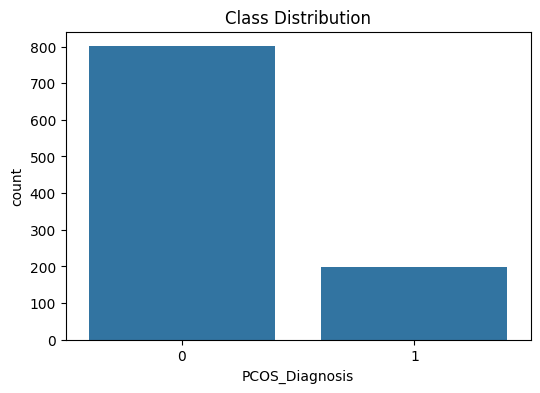

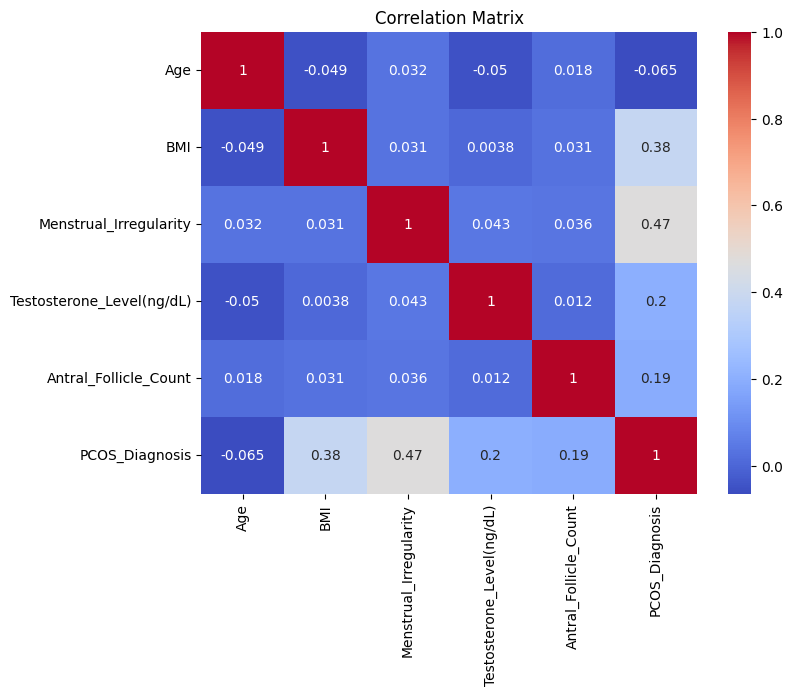

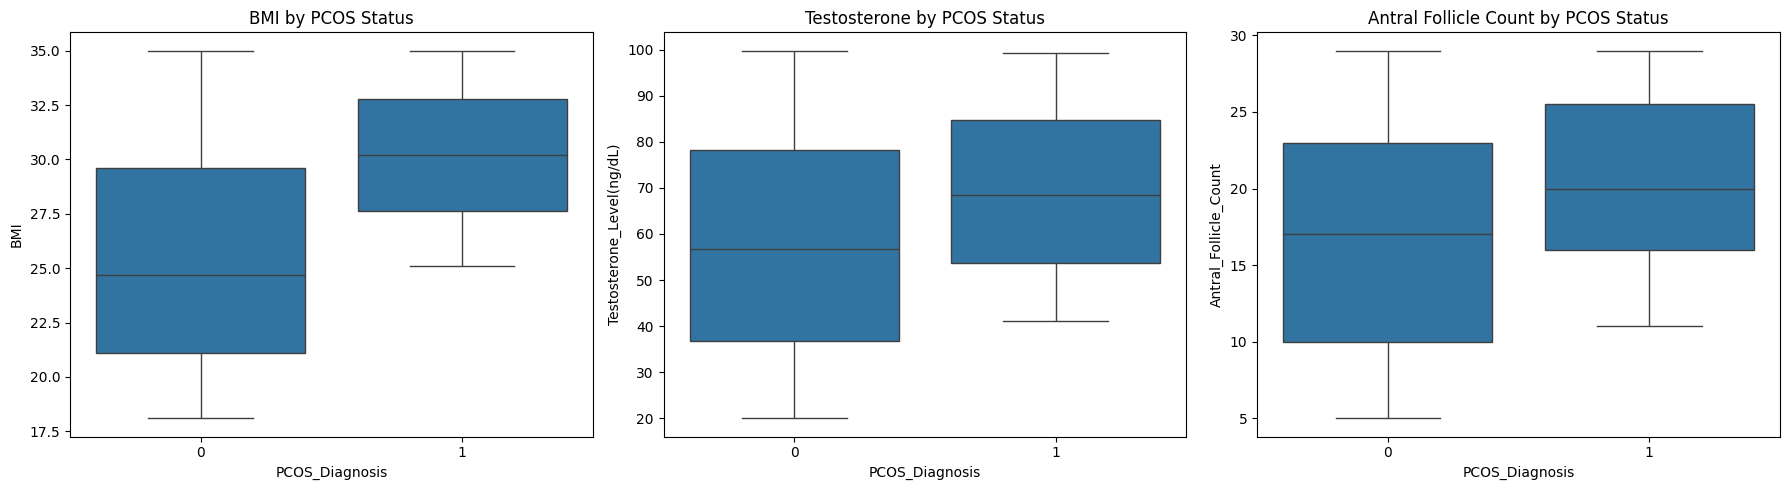

Resampled class distribution:
 PCOS_Diagnosis
0    561
1    561
Name: count, dtype: int64 

RF best params: {'max_depth': 10, 'n_estimators': 100}
XGB best params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100} 

--- Random Forest ---
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



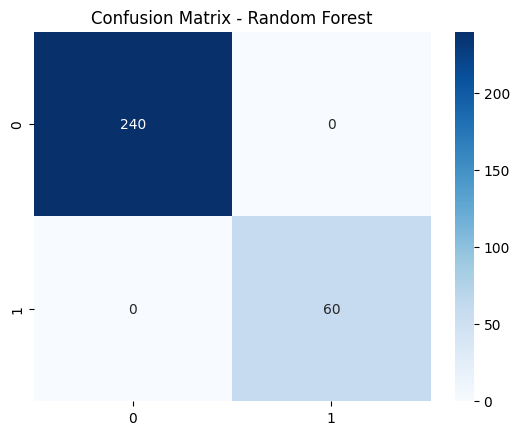

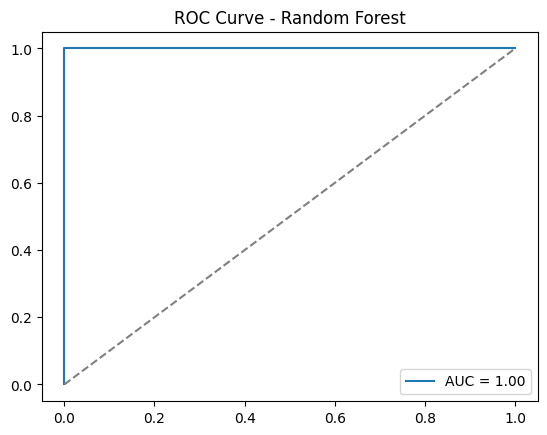

--- XGBoost ---
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



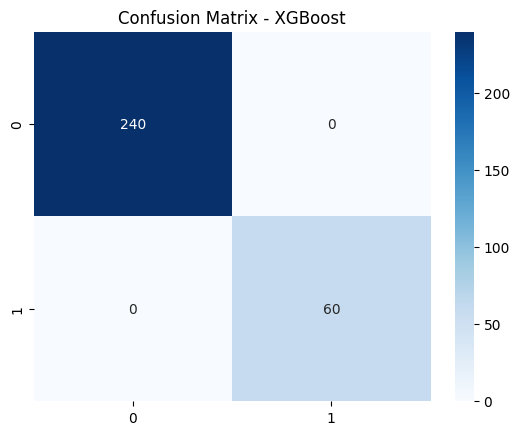

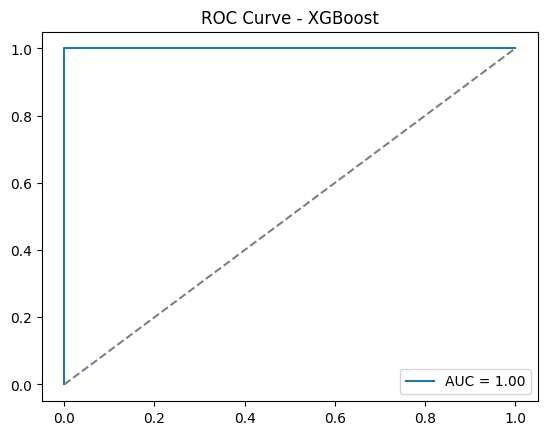

--- Stacked Ensemble ---
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



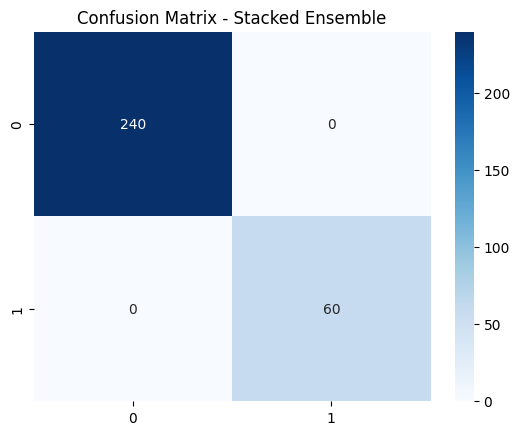

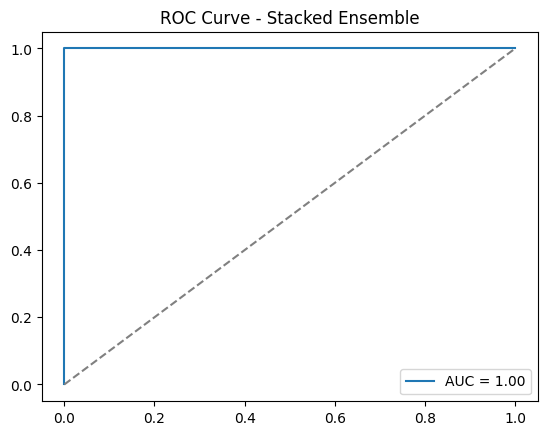

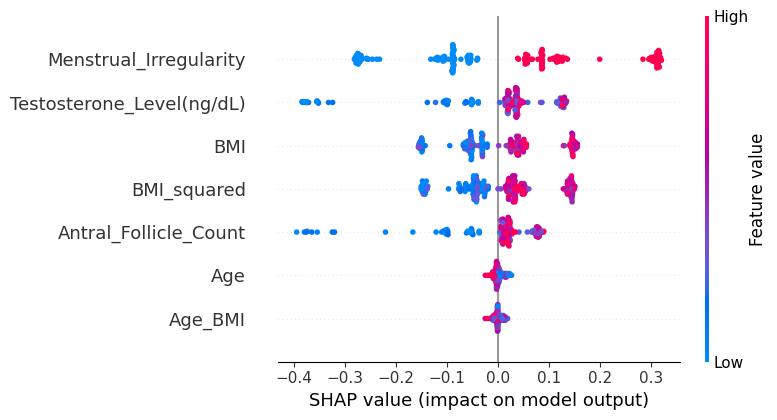

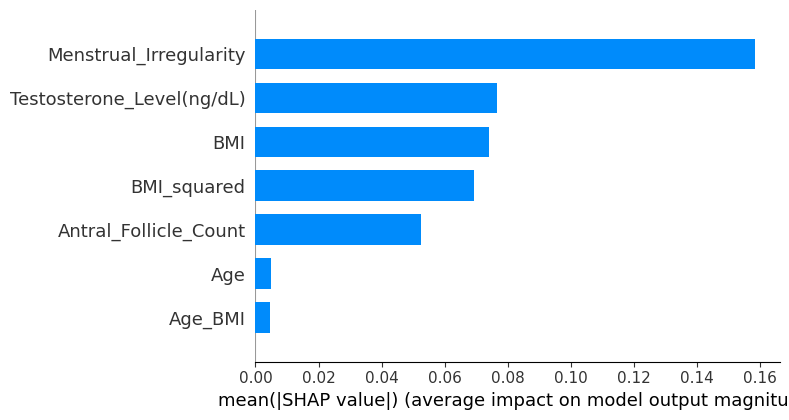

Cross‑Validation Scores (RF):
Accuracy: 0.999 ± 0.002
Precision: 1.000 ± 0.000
Recall: 0.995 ± 0.010
F1: 0.997 ± 0.005


In [ ]:
# ─── Install required libraries (Google Colab) ─────────────────────────────────
!pip install xgboost shap imbalanced-learn umap-learn

# ─── Suppress Warnings ─────────────────────────────────────────────────────────
import warnings
warnings.filterwarnings('ignore')

# ─── Imports ────────────────────────────────────────────────────────────────────
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
# Optional: UMAP (comment out if not installed)
# import umap

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, make_scorer
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# ─── Step 1: Load Data ────────────────────────────────────────────────────────────
df = pd.read_csv('/content/pcos_dataset.csv')
print("Dataset preview:")
print(df.head(), "\n")
print("Missing values per column:\n", df.isnull().sum(), "\n")

# ─── Step 2: Preprocessing ────────────────────────────────────────────────────────
base_features = [
    'Age',
    'BMI',
    'Menstrual_Irregularity',
    'Testosterone_Level(ng/dL)',
    'Antral_Follicle_Count'
]
X_base = df[base_features]
y      = df['PCOS_Diagnosis']

# ─── Step 3: Exploratory Data Analysis ────────────────────────────────────────────
plt.figure(figsize=(6,4))
sns.countplot(x='PCOS_Diagnosis', data=df)      # ← corrected here
plt.title('Class Distribution')
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

fig, axs = plt.subplots(1,3, figsize=(18,5))
sns.boxplot(x='PCOS_Diagnosis', y='BMI', data=df, ax=axs[0])
axs[0].set_title('BMI by PCOS Status')
sns.boxplot(x='PCOS_Diagnosis', y='Testosterone_Level(ng/dL)', data=df, ax=axs[1])
axs[1].set_title('Testosterone by PCOS Status')
sns.boxplot(x='PCOS_Diagnosis', y='Antral_Follicle_Count', data=df, ax=axs[2])
axs[2].set_title('Antral Follicle Count by PCOS Status')
plt.tight_layout()
plt.show()

# ─── Step 4: Feature Engineering & Scaling ────────────────────────────────────────
df['Age_BMI']     = df['Age'] * df['BMI']
df['BMI_squared'] = df['BMI'] ** 2

selected_features = base_features + ['Age_BMI', 'BMI_squared']
X_eng = df[selected_features]

scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X_eng)

# ─── Step 5: (Optional) UMAP ─────────────────────────────────────────────────────
# If UMAP is installed, uncomment:
# reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=5, random_state=42)
# X_red   = reducer.fit_transform(X_scaled)
# Otherwise:
X_red = X_scaled

# ─── Step 6: Train/Test Split & SMOTE ─────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X_red, y, test_size=0.3, stratify=y, random_state=42
)
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)
print("Resampled class distribution:\n", pd.Series(y_train).value_counts(), "\n")

# ─── Step 7: Hyperparameter Tuning ────────────────────────────────────────────────
rf      = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(
    rf,
    {'n_estimators': [100,150], 'max_depth': [10,20]},
    cv=5, scoring='accuracy'
).fit(X_train, y_train)
print("RF best params:", grid_rf.best_params_)

xgb       = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid_xgb  = GridSearchCV(
    xgb,
    {'n_estimators': [100], 'max_depth': [5,7], 'learning_rate': [0.05,0.1]},
    cv=5, scoring='accuracy'
).fit(X_train, y_train)
print("XGB best params:", grid_xgb.best_params_, "\n")

stack_clf = StackingClassifier(
    estimators=[
        ('rf', grid_rf.best_estimator_),
        ('xgb', grid_xgb.best_estimator_),
        ('lr', LogisticRegression(max_iter=1000, random_state=42))
    ],
    final_estimator=LogisticRegression(),
    passthrough=True
).fit(X_train, y_train)

# ─── Step 8: Evaluation ────────────────────────────────────────────────────────────
def evaluate_model(name, model):
    print(f"--- {name} ---")
    y_pred = model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.2f}")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()

evaluate_model("Random Forest", grid_rf.best_estimator_)
evaluate_model("XGBoost", grid_xgb.best_estimator_)
evaluate_model("Stacked Ensemble", stack_clf)

# ─── Step 9: SHAP Analysis ───────────────────────────────────────────────────────
rf_shap = RandomForestClassifier(random_state=42)
rf_shap.fit(X_eng, y)
X_sub = shap.sample(X_eng, 200, random_state=42)
explainer = shap.Explainer(rf_shap, X_sub)
shap_vals = explainer(X_sub)

shap.summary_plot(shap_vals.values[:,:,1], X_sub,
                  feature_names=selected_features, show=False)
plt.tight_layout(); plt.show()

shap.summary_plot(shap_vals.values[:,:,1], X_sub,
                  feature_names=selected_features,
                  plot_type='bar', show=False)
plt.tight_layout(); plt.show()

# ─── Step 10: Cross‑Validation Metrics ─────────────────────────────────────────────
rf_cv = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
skf   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
sc    = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1': make_scorer(f1_score)
}
print("Cross‑Validation Scores (RF):")
for metric, scorer in sc.items():
    scores = cross_val_score(rf_cv, X_red, y, cv=skf, scoring=scorer)
    print(f"{metric}: {scores.mean():.3f} ± {scores.std():.3f}")


   Age   BMI  Menstrual_Irregularity  Testosterone_Level(ng/dL)  \
0   24  34.7                       1                       25.2   
1   37  26.4                       0                       57.1   
2   32  23.6                       0                       92.7   
3   28  28.8                       0                       63.1   
4   25  22.1                       1                       59.8   

   Antral_Follicle_Count  PCOS_Diagnosis  
0                     20               0  
1                     25               0  
2                     28               0  
3                     26               0  
4                      8               0   
Missing:
 Age                          0
BMI                          0
Menstrual_Irregularity       0
Testosterone_Level(ng/dL)    0
Antral_Follicle_Count        0
PCOS_Diagnosis               0
dtype: int64 



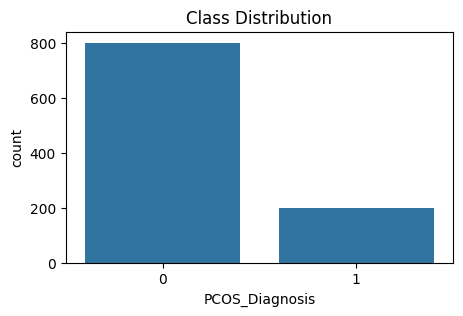

After noise, class counts: [563 559] 

RF best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 150}
XGB best params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7} 

--- Random Forest ---
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



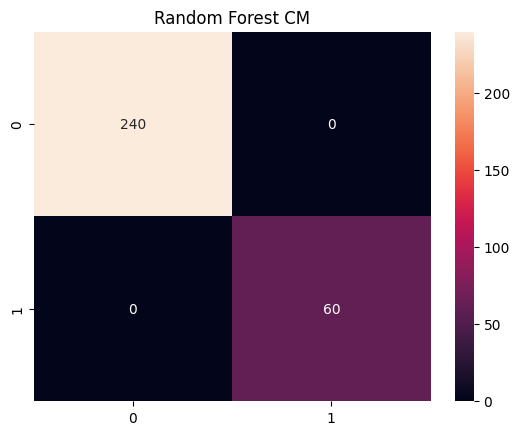

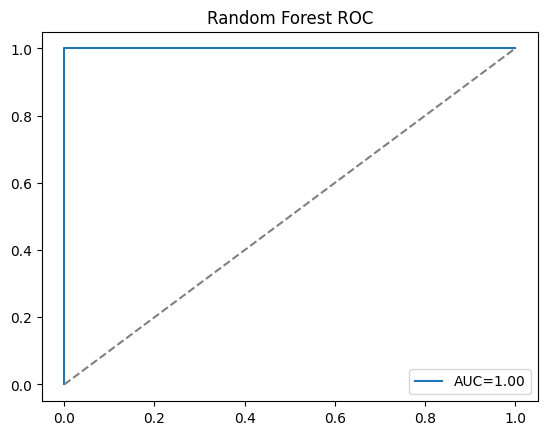

--- XGBoost ---
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00        60

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



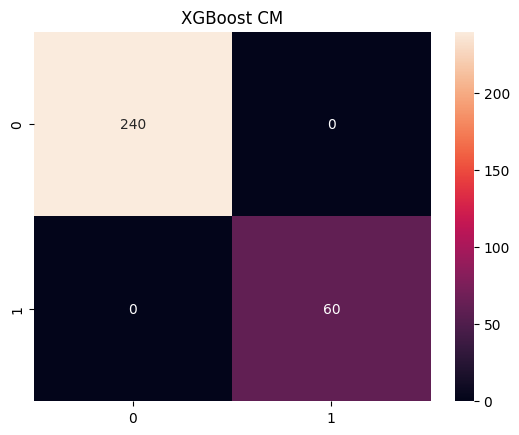

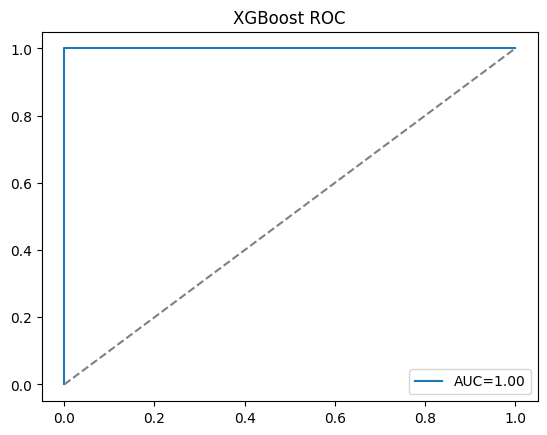

CV Scores (RF):
Accuracy: 0.999 ± 0.002
Precision: 1.000 ± 0.000
Recall: 0.995 ± 0.010
F1: 0.997 ± 0.005


In [ ]:
# ─── Install / Imports ─────────────────────────────────────────────────────────
!pip install xgboost shap imbalanced-learn umap-learn

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection  import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics         import confusion_matrix, classification_report, roc_curve, auc, make_scorer
from sklearn.ensemble        import RandomForestClassifier
from xgboost                 import XGBClassifier
from imblearn.over_sampling  import SMOTE

# ─── 1) Load & Quick EDA ───────────────────────────────────────────────────────
df = pd.read_csv('/content/pcos_dataset.csv')
print(df.head(), "\nMissing:\n", df.isnull().sum(), "\n")

plt.figure(figsize=(5,3))
sns.countplot(x='PCOS_Diagnosis', data=df)
plt.title('Class Distribution'); plt.show()

# ─── 2) Feature Engineering ─────────────────────────────────────────────────────
df['Age_BMI']     = df['Age'] * df['BMI']
df['BMI_squared'] = df['BMI']**2

features = [
  'Age','BMI','Menstrual_Irregularity',
  'Testosterone_Level(ng/dL)','Antral_Follicle_Count',
  'Age_BMI','BMI_squared'
]
X = df[features].values
y = df['PCOS_Diagnosis'].values

# ─── 3) Scale (and optionally UMAP) ─────────────────────────────────────────────
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)

# If you have umap:
# import umap
# X_red = umap.UMAP(n_neighbors=15,min_dist=0.1,n_components=5,random_state=42).fit_transform(X_scaled)
X_red = X_scaled

# ─── 4) Split, SMOTE & Label Noise ──────────────────────────────────────────────
X_tr, X_te, y_tr, y_te = train_test_split(
    X_red, y, test_size=0.3, stratify=y, random_state=42
)
# balance
X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_tr, y_tr)

# inject 5% label noise
rng = np.random.RandomState(42)
n_flip = int(0.05 * len(y_tr))
flip_idx = rng.choice(len(y_tr), size=n_flip, replace=False)
y_tr[flip_idx] = 1 - y_tr[flip_idx]
print("After noise, class counts:", np.bincount(y_tr), "\n")

# ─── 5) Hyperparameter Tuning ───────────────────────────────────────────────────
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {
  'n_estimators':    [100,150],
  'max_depth':       [10,20],
  'max_features':    ['sqrt'],
  'min_samples_leaf':[5]
}
rf_cv = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy').fit(X_tr, y_tr)
print("RF best params:", rf_cv.best_params_)

# XGBoost
xgb = XGBClassifier(random_state=42,use_label_encoder=False,eval_metric='logloss')
xgb_params = {
  'n_estimators':[100],
  'max_depth':[5,7],
  'learning_rate':[0.05,0.1],
  'gamma':[0,1],
  'subsample':[0.7,1.0],
  'colsample_bytree':[0.7,1.0]
}
xgb_cv = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy').fit(X_tr, y_tr)
print("XGB best params:", xgb_cv.best_params_, "\n")

# ─── 6) Single‑Model Eval ───────────────────────────────────────────────────────
def eval_model(name, model):
    y_pred = model.predict(X_te)
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_te,y_pred))
    print(classification_report(y_te,y_pred))
    sns.heatmap(confusion_matrix(y_te,y_pred), annot=True, fmt='d'); plt.title(f"{name} CM"); plt.show()
    if hasattr(model,'predict_proba'):
      p = model.predict_proba(X_te)[:,1]
      fpr,tpr,_ = roc_curve(y_te,p)
      plt.plot(fpr,tpr,label=f"AUC={auc(fpr,tpr):.2f}")
      plt.plot([0,1],[0,1],'--',color='gray'); plt.title(f"{name} ROC"); plt.legend(); plt.show()

eval_model("Random Forest", rf_cv.best_estimator_)
eval_model("XGBoost", xgb_cv.best_estimator_)

# ─── 7) CV Metrics on RF ─────────────────────────────────────────────────────────
rf_final = RandomForestClassifier(**rf_cv.best_params_, random_state=42)
skf      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers  = {
  'Accuracy': make_scorer(accuracy_score),
  'Precision':make_scorer(precision_score),
  'Recall':   make_scorer(recall_score),
  'F1':       make_scorer(f1_score)
}
print("CV Scores (RF):")
for m, sc in scorers.items():
    scores = cross_val_score(rf_final, X_red, y, cv=skf, scoring=sc)
    print(f"{m}: {scores.mean():.3f} ± {scores.std():.3f}")


   Age   BMI  Menstrual_Irregularity  Testosterone_Level(ng/dL)  \
0   24  34.7                       1                       25.2   
1   37  26.4                       0                       57.1   
2   32  23.6                       0                       92.7   
3   28  28.8                       0                       63.1   
4   25  22.1                       1                       59.8   

   Antral_Follicle_Count  PCOS_Diagnosis  
0                     20               0  
1                     25               0  
2                     28               0  
3                     26               0  
4                      8               0   
Missing:
 Age                          0
BMI                          0
Menstrual_Irregularity       0
Testosterone_Level(ng/dL)    0
Antral_Follicle_Count        0
PCOS_Diagnosis               0
dtype: int64 



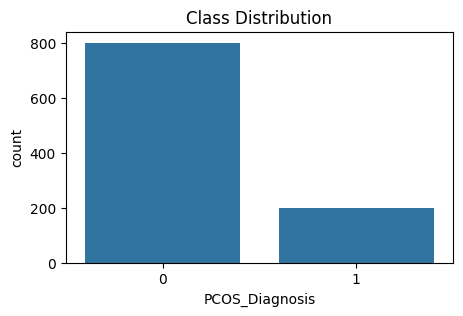

After noise, class counts: [569 553] 

RF best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}
XGB best params: {'colsample_bytree': 0.7, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0} 

--- Random Forest ---
Accuracy: 0.99
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       240
           1       0.95      1.00      0.98        60

    accuracy                           0.99       300
   macro avg       0.98      0.99      0.98       300
weighted avg       0.99      0.99      0.99       300



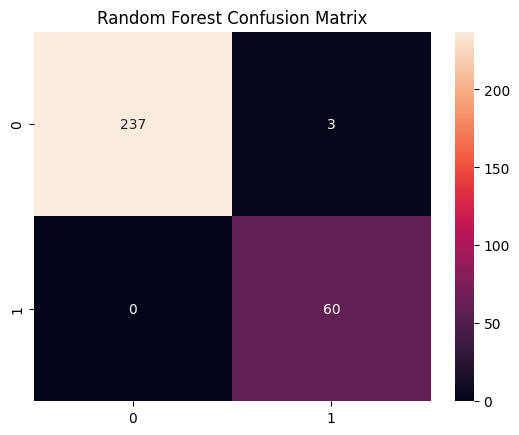

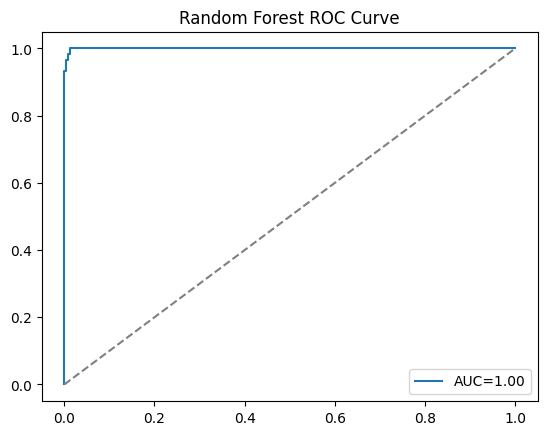

--- XGBoost ---
Accuracy: 0.9766666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       240
           1       0.90      1.00      0.94        60

    accuracy                           0.98       300
   macro avg       0.95      0.99      0.97       300
weighted avg       0.98      0.98      0.98       300



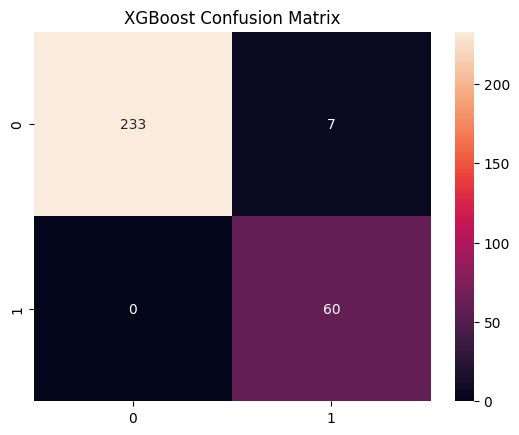

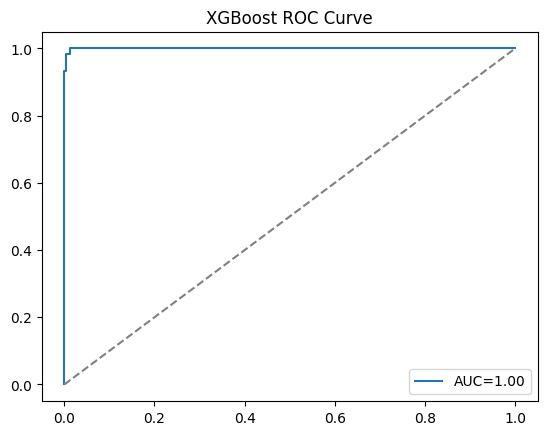

CV Scores (RF):
Accuracy: 0.998 ± 0.002
Precision: 1.000 ± 0.000
Recall: 0.990 ± 0.012
F1: 0.995 ± 0.006


In [ ]:
# ─── Install / Imports ─────────────────────────────────────────────────────────
!pip install xgboost shap imbalanced-learn umap-learn

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection  import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, make_scorer
)
from sklearn.ensemble        import RandomForestClassifier
from xgboost                 import XGBClassifier
from imblearn.over_sampling  import SMOTE

# ─── 1) Load & Quick EDA ───────────────────────────────────────────────────────
df = pd.read_csv('/content/pcos_dataset.csv')
print(df.head(), "\nMissing:\n", df.isnull().sum(), "\n")

plt.figure(figsize=(5,3))
sns.countplot(x='PCOS_Diagnosis', data=df)
plt.title('Class Distribution'); plt.show()

# ─── 2) Feature Engineering ─────────────────────────────────────────────────────
df['Age_BMI']     = df['Age'] * df['BMI']
df['BMI_squared'] = df['BMI']**2

features = [
  'Age','BMI','Menstrual_Irregularity',
  'Testosterone_Level(ng/dL)','Antral_Follicle_Count',
  'Age_BMI','BMI_squared'
]
X = df[features].values
y = df['PCOS_Diagnosis'].values

# ─── 3) Scale (and optionally UMAP) ─────────────────────────────────────────────
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)

# If you have UMAP installed:
# import umap
# X_red = umap.UMAP(n_neighbors=15,min_dist=0.1,n_components=5,random_state=42).fit_transform(X_scaled)
X_red = X_scaled

# ─── 4) Split, SMOTE & Noise Injection ──────────────────────────────────────────
X_tr, X_te, y_tr, y_te = train_test_split(
    X_red, y, test_size=0.3, stratify=y, random_state=42
)
# balance classes
X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_tr, y_tr)

# inject 10% label noise
rng = np.random.RandomState(42)
noise_frac = 0.10
n_flip     = int(noise_frac * len(y_tr))
flip_idx   = rng.choice(len(y_tr), size=n_flip, replace=False)
y_tr[flip_idx] = 1 - y_tr[flip_idx]

# inject small Gaussian feature noise
feature_noise_sigma = 0.1
X_tr += rng.normal(0, feature_noise_sigma, X_tr.shape)

print("After noise, class counts:", np.bincount(y_tr), "\n")

# ─── 5) Hyperparameter Tuning ───────────────────────────────────────────────────
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf_params = {
  'n_estimators':    [100,150],
  'max_depth':       [10,20],
  'max_features':    ['sqrt'],
  'min_samples_leaf':[5]
}
rf_cv = GridSearchCV(rf, rf_params, cv=5, scoring='accuracy').fit(X_tr, y_tr)
print("RF best params:", rf_cv.best_params_)

# XGBoost
xgb = XGBClassifier(random_state=42,use_label_encoder=False,eval_metric='logloss')
xgb_params = {
  'n_estimators':[100],
  'max_depth':[5,7],
  'learning_rate':[0.05,0.1],
  'gamma':[0,1],
  'subsample':[0.7,1.0],
  'colsample_bytree':[0.7,1.0]
}
xgb_cv = GridSearchCV(xgb, xgb_params, cv=5, scoring='accuracy').fit(X_tr, y_tr)
print("XGB best params:", xgb_cv.best_params_, "\n")

# ─── 6) Single‑Model Eval ───────────────────────────────────────────────────────
def eval_model(name, model):
    y_pred = model.predict(X_te)
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_te, y_pred))
    print(classification_report(y_te, y_pred))
    sns.heatmap(confusion_matrix(y_te, y_pred), annot=True, fmt='d')
    plt.title(f"{name} Confusion Matrix"); plt.show()
    if hasattr(model,'predict_proba'):
        p = model.predict_proba(X_te)[:,1]
        fpr, tpr, _ = roc_curve(y_te, p)
        plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.2f}")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.title(f"{name} ROC Curve"); plt.legend(); plt.show()

eval_model("Random Forest", rf_cv.best_estimator_)
eval_model("XGBoost", xgb_cv.best_estimator_)

# ─── 7) CV Metrics on RF ─────────────────────────────────────────────────────────
rf_final = RandomForestClassifier(**rf_cv.best_params_, random_state=42)
skf      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers  = {
  'Accuracy': make_scorer(accuracy_score),
  'Precision':make_scorer(precision_score),
  'Recall':   make_scorer(recall_score),
  'F1':       make_scorer(f1_score)
}
print("CV Scores (RF):")
for m, sc in scorers.items():
    scores = cross_val_score(rf_final, X_red, y, cv=skf, scoring=sc)
    print(f"{m}: {scores.mean():.3f} ± {scores.std():.3f}")


   Age   BMI  Menstrual_Irregularity  Testosterone_Level(ng/dL)  \
0   24  34.7                       1                       25.2   
1   37  26.4                       0                       57.1   
2   32  23.6                       0                       92.7   
3   28  28.8                       0                       63.1   
4   25  22.1                       1                       59.8   

   Antral_Follicle_Count  PCOS_Diagnosis  
0                     20               0  
1                     25               0  
2                     28               0  
3                     26               0  
4                      8               0   
Missing:
 Age                          0
BMI                          0
Menstrual_Irregularity       0
Testosterone_Level(ng/dL)    0
Antral_Follicle_Count        0
PCOS_Diagnosis               0
dtype: int64 



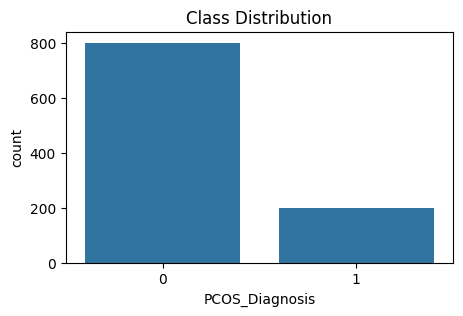

Post-noise label counts: [567 555] 

RF params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 150}
XGB params: {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7} 

--- Random Forest ---
Accuracy: 0.96
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       240
           1       0.83      1.00      0.91        60

    accuracy                           0.96       300
   macro avg       0.92      0.97      0.94       300
weighted avg       0.97      0.96      0.96       300



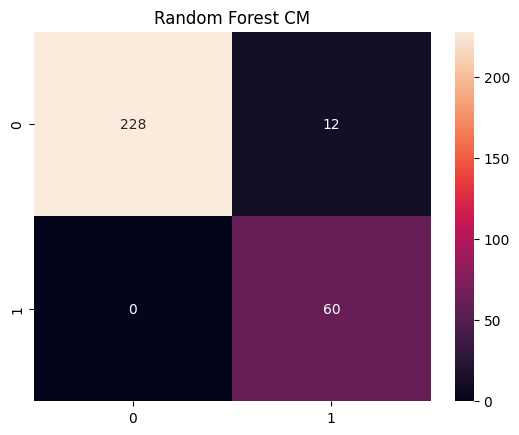

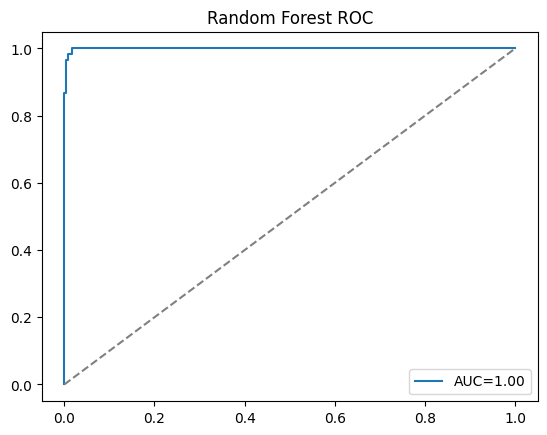

--- XGBoost ---
Accuracy: 0.9533333333333334
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       240
           1       0.81      1.00      0.90        60

    accuracy                           0.95       300
   macro avg       0.91      0.97      0.93       300
weighted avg       0.96      0.95      0.96       300



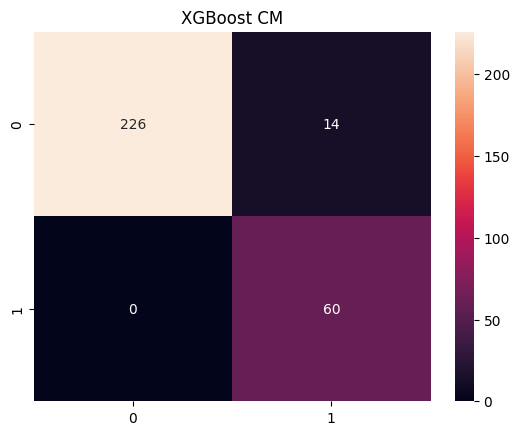

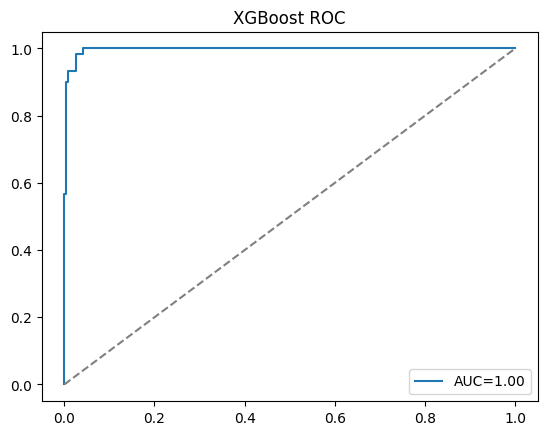

CV Scores (RF):
Accuracy: 0.999 ± 0.002
Precision: 1.000 ± 0.000
Recall: 0.995 ± 0.010
F1: 0.997 ± 0.005


In [ ]:
# ─── Install / Imports ─────────────────────────────────────────────────────────
!pip install xgboost shap imbalanced-learn umap-learn

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection  import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc, make_scorer
)
from sklearn.ensemble        import RandomForestClassifier
from xgboost                 import XGBClassifier
from imblearn.over_sampling  import SMOTE

# ─── 1) Load & EDA ───────────────────────────────────────────────────────────────
df = pd.read_csv('/content/pcos_dataset.csv')
print(df.head(), "\nMissing:\n", df.isnull().sum(), "\n")

plt.figure(figsize=(5,3))
sns.countplot(x='PCOS_Diagnosis', data=df)
plt.title('Class Distribution'); plt.show()

# ─── 2) Feature Engineering ─────────────────────────────────────────────────────
df['Age_BMI']     = df['Age'] * df['BMI']
df['BMI_squared'] = df['BMI'] ** 2

features = [
    'Age','BMI','Menstrual_Irregularity',
    'Testosterone_Level(ng/dL)','Antral_Follicle_Count',
    'Age_BMI','BMI_squared'
]
X = df[features].values
y = df['PCOS_Diagnosis'].values

# ─── 3) Scale (and optionally UMAP) ─────────────────────────────────────────────
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)

# If using UMAP:
# import umap
# X_red = umap.UMAP(n_neighbors=15,min_dist=0.1,n_components=5,random_state=42).fit_transform(X_scaled)
X_red = X_scaled

# ─── 4) Split, SMOTE & Heavy Noise ───────────────────────────────────────────────
X_tr, X_te, y_tr, y_te = train_test_split(
    X_red, y, test_size=0.3, stratify=y, random_state=42
)
X_tr, y_tr = SMOTE(random_state=42).fit_resample(X_tr, y_tr)

# 20% label flips
rng = np.random.RandomState(42)
noise_frac = 0.20
n_flip     = int(noise_frac * len(y_tr))
flip_idx   = rng.choice(len(y_tr), size=n_flip, replace=False)
y_tr[flip_idx] = 1 - y_tr[flip_idx]

# σ=0.3 Gaussian feature noise
feature_noise_sigma = 0.3
X_tr += rng.normal(0, feature_noise_sigma, X_tr.shape)

print("Post-noise label counts:", np.bincount(y_tr), "\n")

# ─── 5) Hyperparameter Tuning ───────────────────────────────────────────────────
rf_params = {
    'n_estimators':    [100,150],
    'max_depth':       [10,20],
    'max_features':    ['sqrt'],
    'min_samples_leaf':[5]
}
rf_cv = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params, cv=5, scoring='accuracy'
).fit(X_tr, y_tr)
print("RF params:", rf_cv.best_params_)

xgb_params = {
    'n_estimators':    [100],
    'max_depth':       [5,7],
    'learning_rate':   [0.05,0.1],
    'gamma':           [0,1],
    'subsample':       [0.7,1.0],
    'colsample_bytree':[0.7,1.0]
}
xgb_cv = GridSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    xgb_params, cv=5, scoring='accuracy'
).fit(X_tr, y_tr)
print("XGB params:", xgb_cv.best_params_, "\n")

# ─── 6) Single‑Model Evaluation ───────────────────────────────────────────────────
def eval_model(name, model):
    y_pred = model.predict(X_te)
    print(f"--- {name} ---")
    print("Accuracy:", accuracy_score(y_te, y_pred))
    print(classification_report(y_te, y_pred))
    sns.heatmap(confusion_matrix(y_te, y_pred), annot=True, fmt='d')
    plt.title(f"{name} CM"); plt.show()
    if hasattr(model,'predict_proba'):
        p = model.predict_proba(X_te)[:,1]
        fpr, tpr, _ = roc_curve(y_te, p)
        plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.2f}")
        plt.plot([0,1],[0,1],'--', color='gray')
        plt.title(f"{name} ROC"); plt.legend(); plt.show()

eval_model("Random Forest", rf_cv.best_estimator_)
eval_model("XGBoost", xgb_cv.best_estimator_)

# ─── 7) CV Metrics (RF) ─────────────────────────────────────────────────────────
rf_final = RandomForestClassifier(**rf_cv.best_params_, random_state=42)
skf      = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers  = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision':make_scorer(precision_score),
    'Recall':   make_scorer(recall_score),
    'F1':       make_scorer(f1_score)
}
print("CV Scores (RF):")
for m, sc in scorers.items():
    scores = cross_val_score(rf_final, X_red, y, cv=skf, scoring=sc)
    print(f"{m}: {scores.mean():.3f} ± {scores.std():.3f}")


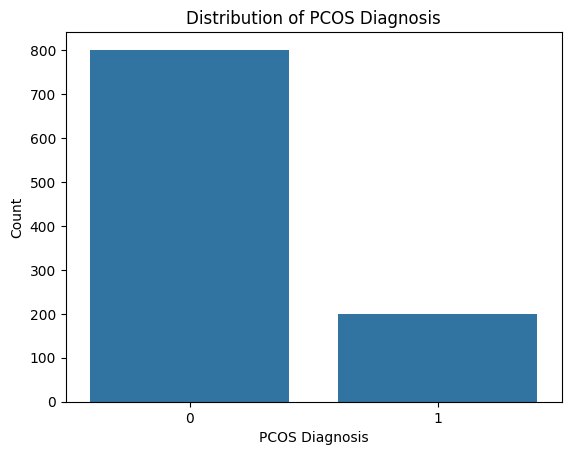

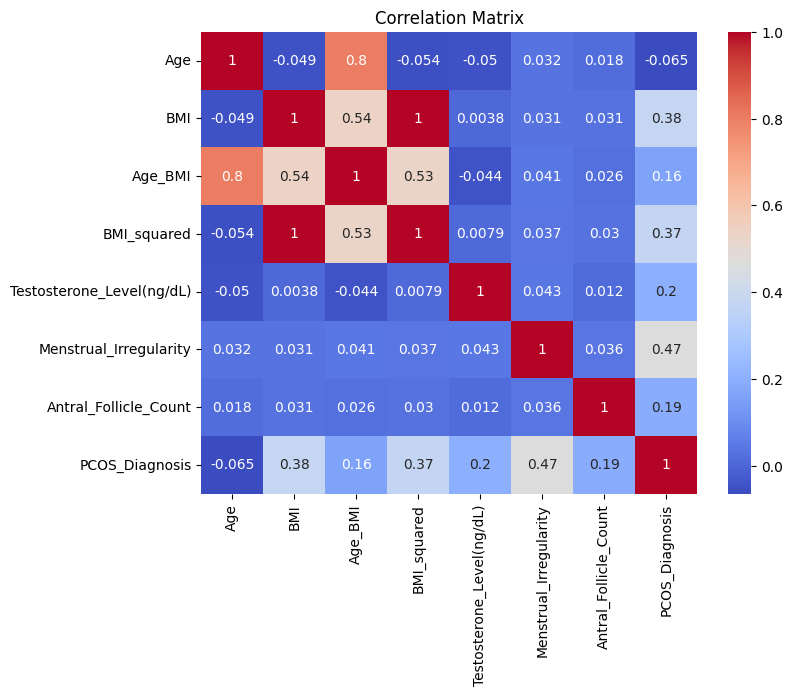

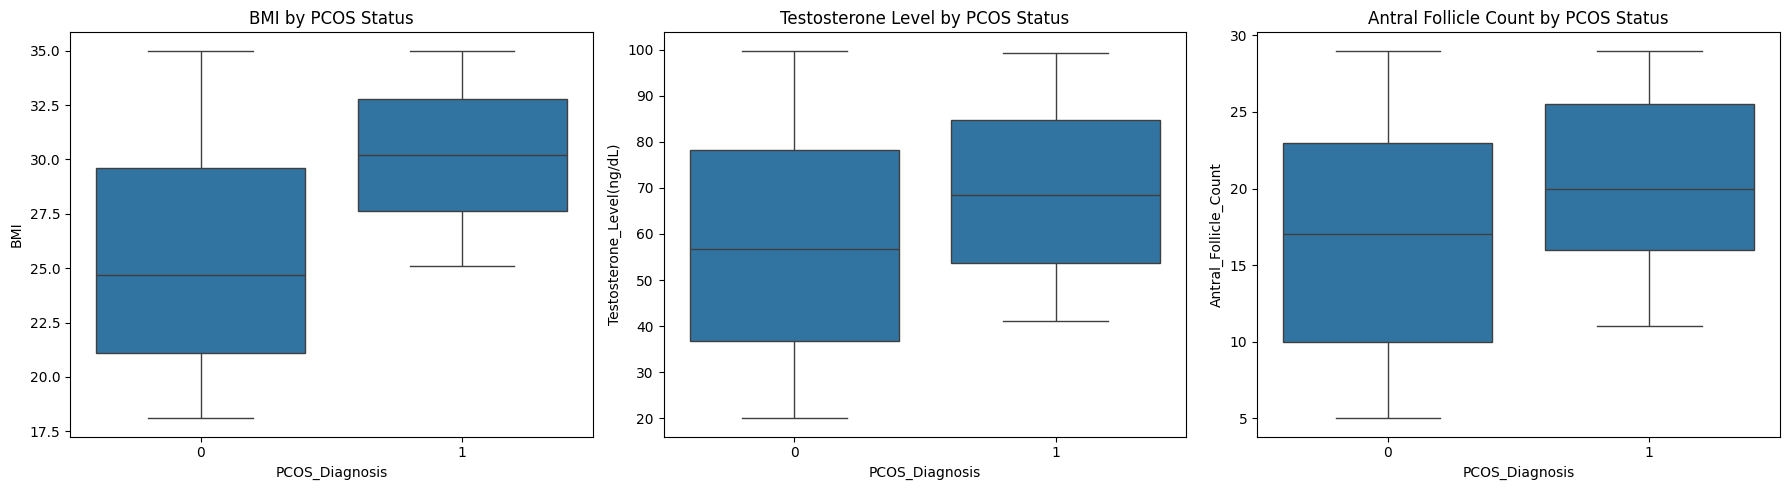

Resampled class distribution:
 PCOS_Diagnosis
0    561
1    561
Name: count, dtype: int64
Random Forest best parameters: {'max_depth': 20, 'n_estimators': 100}
XGBoost best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Random Forest Accuracy: 0.9467
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       240
           1       0.81      0.95      0.88        60

    accuracy                           0.95       300
   macro avg       0.90      0.95      0.92       300
weighted avg       0.95      0.95      0.95       300



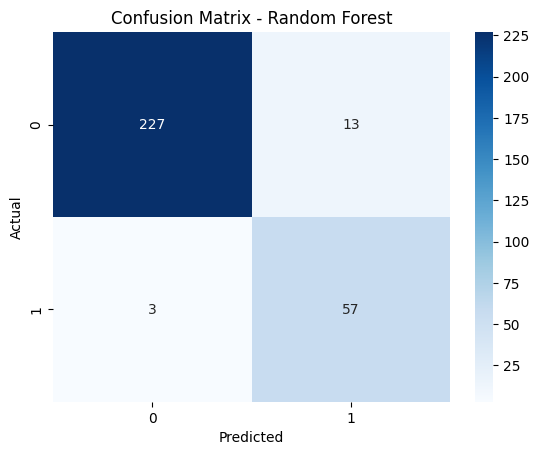

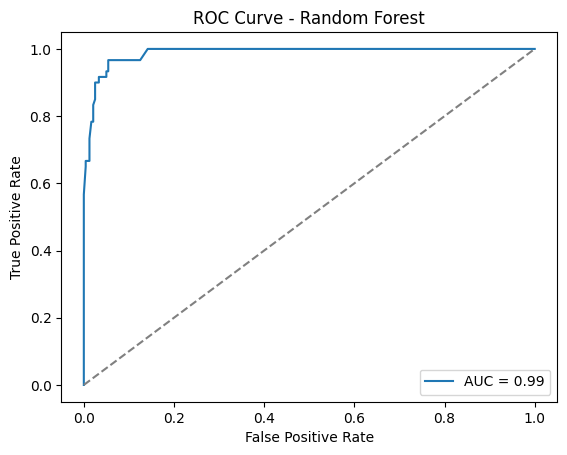


XGBoost Accuracy: 0.9633
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       240
           1       0.87      0.97      0.91        60

    accuracy                           0.96       300
   macro avg       0.93      0.96      0.95       300
weighted avg       0.97      0.96      0.96       300



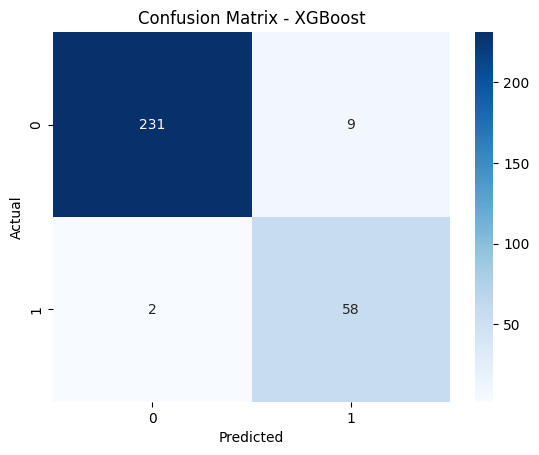

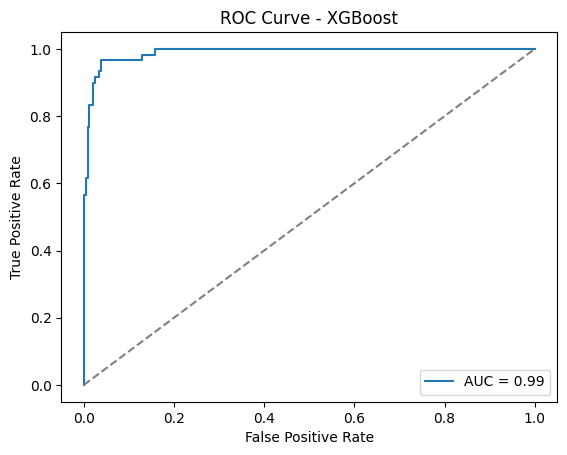


Stacked Ensemble Accuracy: 0.9600
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       240
           1       0.86      0.95      0.90        60

    accuracy                           0.96       300
   macro avg       0.93      0.96      0.94       300
weighted avg       0.96      0.96      0.96       300



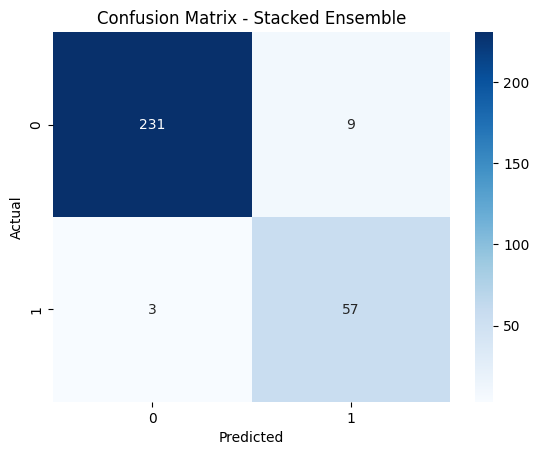

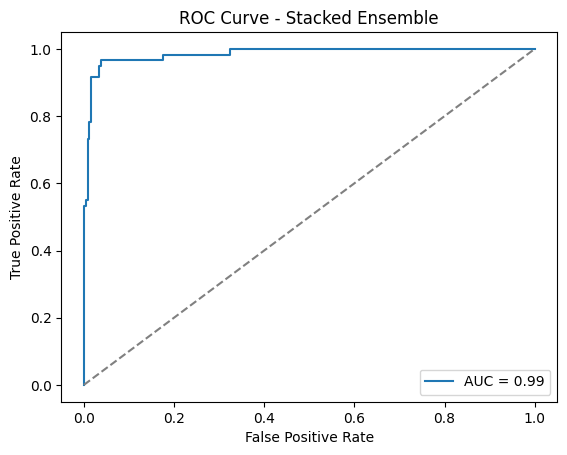

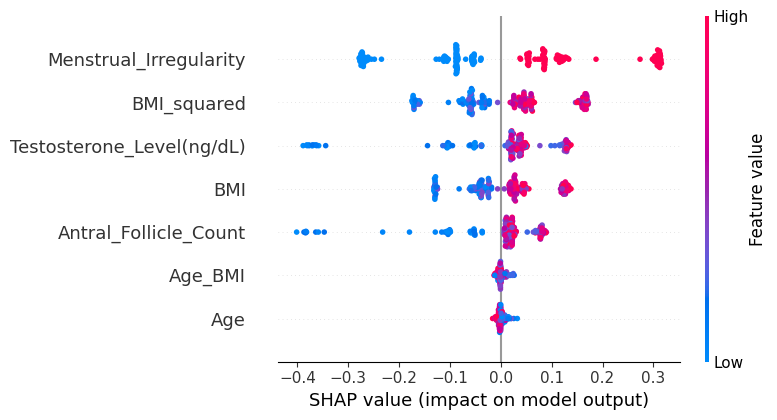

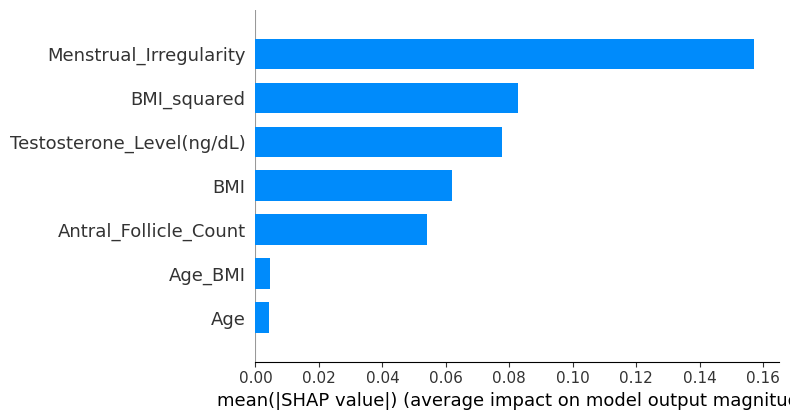


Cross-Validation Scores:
Accuracy: 0.947 ± 0.010
Precision: 0.879 ± 0.050
Recall: 0.854 ± 0.039
F1: 0.865 ± 0.026


In [ ]:
# Install required libraries (Google Colab)
!pip install xgboost shap imbalanced-learn umap-learn

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, make_scorer, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
import umap
from sklearn.pipeline import Pipeline
import shap
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv('/content/pcos_dataset.csv')

# Create engineered features
df['Age_BMI'] = df['Age'] * df['BMI']
df['BMI_squared'] = df['BMI'] ** 2

# Include diagnostic features to boost model performance
selected_features = [
    'Age', 'BMI', 'Age_BMI', 'BMI_squared',
    'Testosterone_Level(ng/dL)',
    'Menstrual_Irregularity',
    'Antral_Follicle_Count'
]
X = df[selected_features]
y = df['PCOS_Diagnosis']

# === 📊 Visualization ===
# Class distribution
sns.countplot(x='PCOS_Diagnosis', data=df)
plt.title('Distribution of PCOS Diagnosis')
plt.xlabel('PCOS Diagnosis')
plt.ylabel('Count')
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[selected_features + ['PCOS_Diagnosis']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature distribution by diagnosis
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.boxplot(x='PCOS_Diagnosis', y='BMI', data=df, ax=axs[0])
axs[0].set_title('BMI by PCOS Status')
sns.boxplot(x='PCOS_Diagnosis', y='Testosterone_Level(ng/dL)', data=df, ax=axs[1])
axs[1].set_title('Testosterone Level by PCOS Status')
sns.boxplot(x='PCOS_Diagnosis', y='Antral_Follicle_Count', data=df, ax=axs[2])
axs[2].set_title('Antral Follicle Count by PCOS Status')
plt.tight_layout()
plt.show()

# === 🔄 Preprocessing ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Optional: UMAP for dimensionality reduction
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=5, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_umap, y, test_size=0.3, stratify=y, random_state=42)

# Apply SMOTE ONLY to training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("Resampled class distribution:\n", pd.Series(y_train).value_counts())

# === 🤖 Modeling ===
rf = RandomForestClassifier(random_state=42)
params_rf = {'n_estimators':[100,150], 'max_depth':[10, 20]}
grid_rf = GridSearchCV(rf, params_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)
print("Random Forest best parameters:", grid_rf.best_params_)

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
params_xgb = {'n_estimators':[100],'max_depth':[5,7],'learning_rate':[0.05,0.1]}
grid_xgb = GridSearchCV(xgb, params_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(X_train, y_train)
print("XGBoost best parameters:", grid_xgb.best_params_)

logreg = LogisticRegression(max_iter=1000, random_state=42)
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', grid_rf.best_estimator_),
        ('xgb', grid_xgb.best_estimator_),
        ('lr', logreg)
    ],
    final_estimator=LogisticRegression(),
    passthrough=True
)
stacking_clf.fit(X_train, y_train)

# === 📈 Evaluation ===
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'AUC = {auc(fpr,tpr):.2f}')
        plt.plot([0,1],[0,1],'--',color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.show()

evaluate_model("Random Forest", grid_rf.best_estimator_)
evaluate_model("XGBoost", grid_xgb.best_estimator_)
evaluate_model("Stacked Ensemble", stacking_clf)

# === 🔍 SHAP Analysis ===
X_full = df[selected_features]
y_full = df['PCOS_Diagnosis']
rf_shap = RandomForestClassifier(random_state=42)
rf_shap.fit(X_full, y_full)
X_sub = shap.sample(X_full, 200, random_state=42)
explainer = shap.Explainer(rf_shap, X_sub)
shap_values = explainer(X_sub)
shap.summary_plot(shap_values.values[:,:,1], X_sub, feature_names=selected_features, show=False)
plt.tight_layout()
plt.show()
shap.summary_plot(shap_values.values[:,:,1], X_sub, feature_names=selected_features, plot_type='bar', show=False)
plt.tight_layout()
plt.show()

# === 🧪 Cross-validation ===
rf_cv = RandomForestClassifier(n_estimators=grid_rf.best_params_['n_estimators'], max_depth=grid_rf.best_params_['max_depth'], random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorers = {'accuracy': make_scorer(accuracy_score), 'precision': make_scorer(precision_score), 'recall': make_scorer(recall_score), 'f1': make_scorer(f1_score)}
print("\nCross-Validation Scores:")
for name, scorer in scorers.items():
    scores = cross_val_score(rf_cv, X_umap, y, cv=skf, scoring=scorer)
    print(f"{name.capitalize()}: {scores.mean():.3f} ± {scores.std():.3f}")

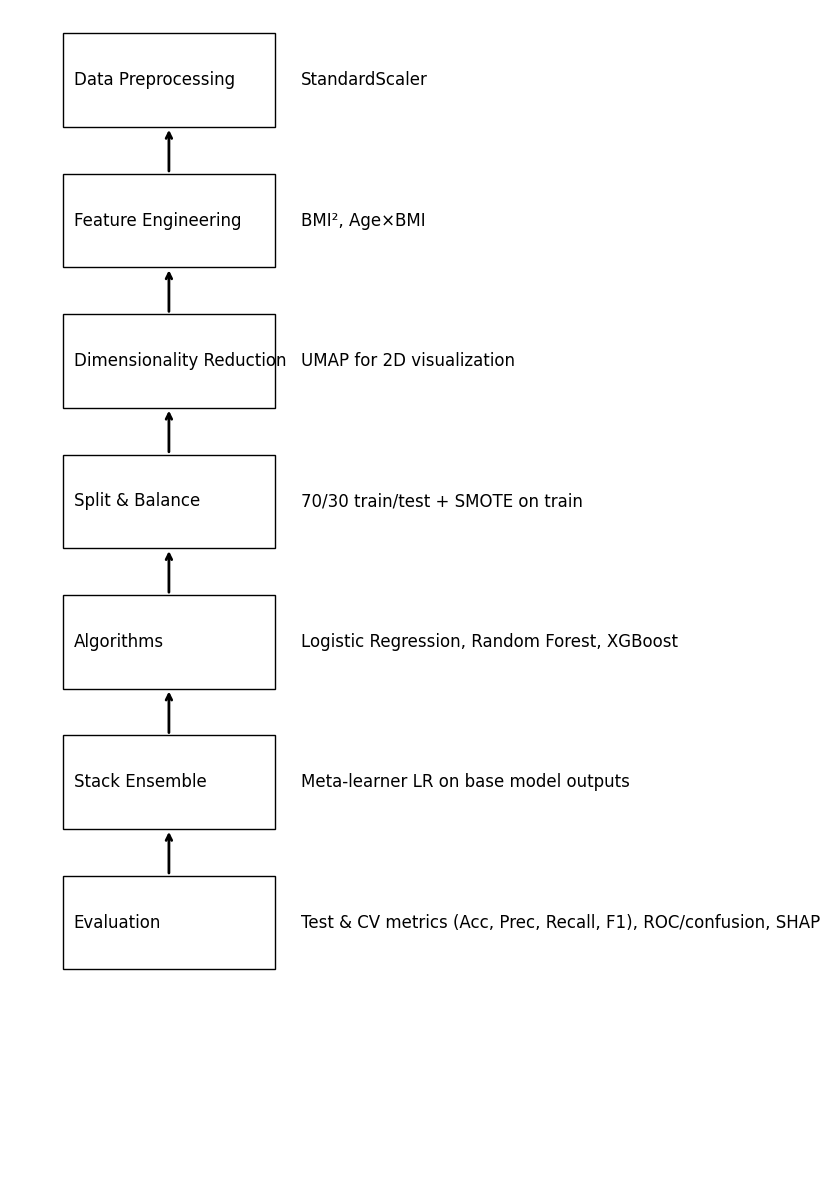

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Pipeline stages and descriptions
stages = [
    "Data Preprocessing",
    "Feature Engineering",
    "Dimensionality Reduction",
    "Split & Balance",
    "Algorithms",
    "Stack Ensemble",
    "Evaluation"
]
descs = [
    "StandardScaler",
    "BMI², Age×BMI",
    "UMAP for 2D visualization",
    "70/30 train/test + SMOTE on train",
    "Logistic Regression, Random Forest, XGBoost",
    "Meta‑learner LR on base model outputs",
    "Test & CV metrics (Acc, Prec, Recall, F1), ROC/confusion, SHAP"
]

# Create figure
fig, ax = plt.subplots(figsize=(8, 12))
ax.axis('off')

# Box and text positions
box_width = 0.4
box_height = 0.08
x_box = 0.1
x_text = x_box + box_width + 0.05

for i, (stage, desc) in enumerate(zip(stages, descs)):
    y = 0.9 - i * 0.12
    # Draw box
    rect = Rectangle((x_box, y), box_width, box_height, fill=False)
    ax.add_patch(rect)
    # Stage text
    ax.text(x_box + 0.02, y + box_height / 2, stage, va='center', fontsize=12)
    # Description text
    ax.text(x_text, y + box_height / 2, desc, va='center', fontsize=12)
    # Draw arrow to next box
    if i < len(stages) - 1:
        ax.annotate(
            "",
            xy=(x_box + box_width / 2, y),
            xytext=(x_box + box_width / 2, y - 0.04),
            arrowprops=dict(arrowstyle="->", lw=2)
        )

plt.tight_layout()
plt.show()
